## Housing Project Segmentation model

import relevent things

In [1]:
import pandas as pd
import numpy as np
import sklearn
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
pd.options.display.max_rows = 10

In [2]:
path=os.getcwd()
data=path+"//Data"
files=os.listdir(data)
files

['austinHousingData.csv', 'portland_housing.csv', '19zpallagi.csv']

In [3]:
FHFA=pd.read_csv(data+"/"+'19zpallagi.csv')

## Austin Prep
preps the austin data set (raw zillow data scrapped from austin metro area) for use in pca model 

In [7]:
file=data+"/"+'austinHousingData.csv'
austin=pd.read_csv(file)
pd.options.display.max_columns = None
pd.options.display.max_rows = 10
#try1.head()

In [8]:
city=austin['zipcode'].unique()
data_city=FHFA.loc[FHFA["zipcode"].isin(city)]
dic={}
for i in data_city["zipcode"].unique():
    subset=data_city[data_city["zipcode"]==i]
    dist=subset.groupby("agi_stub").mean()["N1"]/subset["N1"].sum()
    dic[i]=(subset.groupby("agi_stub").mean()["A00100"]/subset.groupby("agi_stub").mean()["N1"]*dist).sum()
dic2={}
for i in data_city["zipcode"].unique():
    subset=data_city[data_city["zipcode"]==i]
    dist=subset.groupby("agi_stub").mean()["N2"]/subset["N2"].sum()
    dic2[i]=dist[:3].sum()

In [9]:
city=austin['zipcode'].unique()
data_city=FHFA.loc[FHFA["zipcode"].isin(city)]
median_value=dic2
mean_value=dic
fun1=lambda x: mean_value[x]
fun2=lambda x: median_value[x]
austin['expected_return']=austin['zipcode'].apply(fun1)
austin['expected_people']=austin['zipcode'].apply(fun2)
austin_adj=austin.copy()

## Austin PCA / Segment

Creates the actual PCA and segmentation using PCA using a naive approach to pca.  The model removes outliers and does not consider any intutition, treating variables by only variance.  

Variance ratios are :
[0.38616352 0.15449754 0.11133404 0.10015641 0.07517811 0.06699183
 0.04932968]
dropped outliers at % 0.001252389427196625


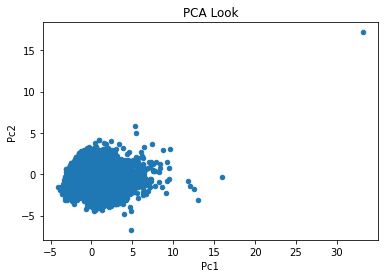

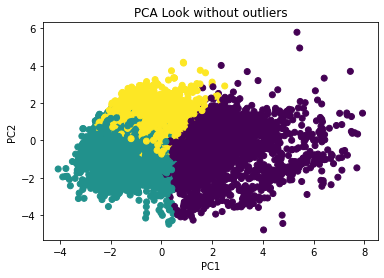

pc1


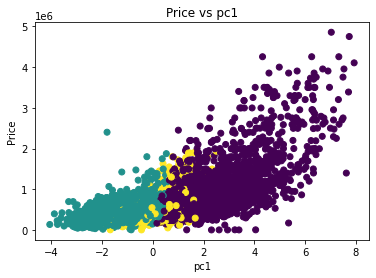

pc2


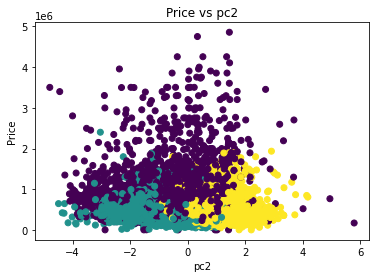

pc3


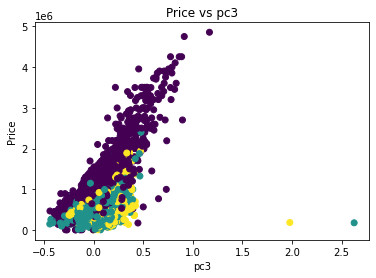

pc4


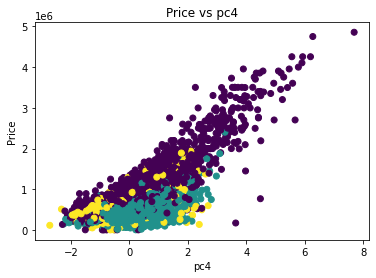

pc5


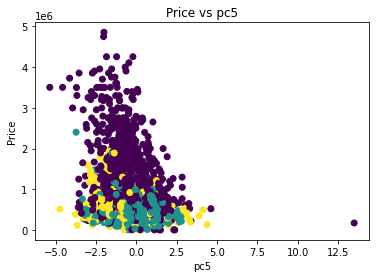

pc6


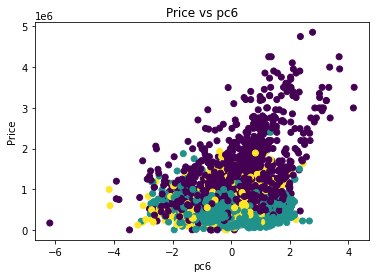

pc7


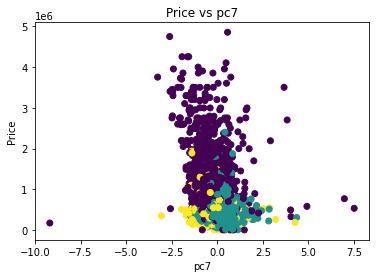

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
austin=austin_adj.copy()
try1=austin[['latestPrice','expected_return','expected_people','yearBuilt','avgSchoolRating','lotSizeSqFt','livingAreaSqFt','numOfBedrooms', 'numOfStories']]
major=8
n_clusters=3
scale=StandardScaler().fit(try1)
try2=scale.transform(try1)
model=PCA(n_components=7).fit(try2)
print("Variance ratios are :")
print(model.explained_variance_ratio_)
values=model.transform(try2)
principalDf = pd.DataFrame(data = values
             , columns = ['pc1', 'pc2',"pc3","pc4",'pc5','pc6','pc7'])
principalDf[['pc1',
       'pc2',]].plot.scatter(x='pc1',y='pc2',title="PCA Look",ylabel="Pc2",xlabel="Pc1")
outlier_pc1=principalDf[principalDf['pc1'] > major].index
outlier_pc2=principalDf[principalDf['pc2'] > major].index
outlier_pc3=principalDf[principalDf['pc3'] > major].index
outs=outlier_pc1.union(outlier_pc2)
outs=outs.union(outlier_pc3)
print("dropped outliers at %" , len(outs)/len(austin))
new=try1.drop(outs)
try2=scale.transform(new)
values=model.transform(try2)
principalDf = pd.DataFrame(data = values
             , columns = ['pc1', 'pc2',"pc3","pc4",'pc5','pc6','pc7'])
plt.show()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(principalDf)
color=np.array(kmeans.labels_)
austin=austin.drop(outs)
austin=austin.reset_index(drop=True)
austin["cluster"]=color
whole=pd.concat([austin,principalDf],axis=1)
plt.scatter(whole['pc1'],whole['pc2'],c=whole['cluster'])
plt.ylabel("PC2")
plt.xlabel("PC1")
plt.title("PCA Look without outliers")
plt.show()
for i in principalDf.columns:
       print(i)
       plt.scatter(whole[i],whole['latestPrice'],c=whole['cluster'])
       plt.ylabel("Price")
       plt.title(f"Price vs {i}")
       plt.xlabel(i)
       plt.show()

Above are all the PCA components if using no assumptions in clustering. 
Note that we can select PCA components that only show a trend in the price because we can guide intuition that price is the key metric of the segmentation.  This reduces the assumptions and removes useless/ un-wanted variance from the set
This is done below (Note that now pc1,pc2 is raw compared to before it has defined segmentation, but when considering price it is segmented well as seen by the 3d vis and remaining pca)

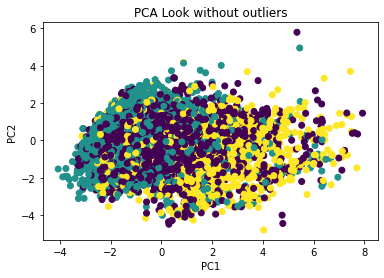

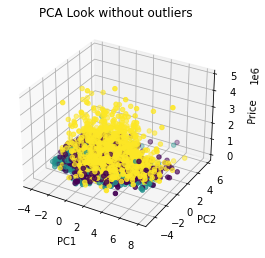

pc1


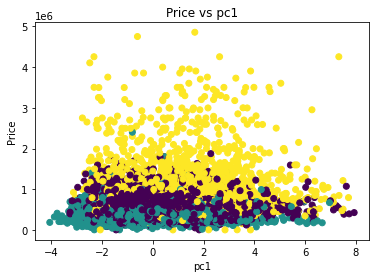

pc3


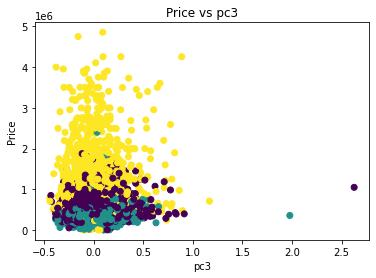

pc4


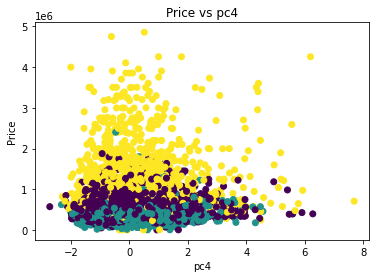

pc6


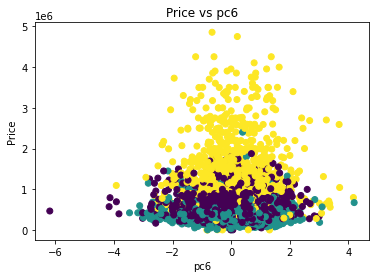

In [18]:
#select pc that show segmentation on axis for prices
# this is because price is the most intuitive deliminator of markets (Ie low/ medium/high, first thing looked at is price)
austin=austin_adj.copy()
new_df=principalDf[["pc1",'pc3',"pc4",'pc6']]
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(new_df)
color=np.array(kmeans.labels_)
austin=austin.reset_index(drop=True)
austin=austin.drop(outs)
austin["cluster"]=color
whole=pd.concat([austin,principalDf],axis=1)
plt.scatter(whole['pc1'],whole['pc2'],c=whole['cluster'])
plt.ylabel("PC2")
plt.xlabel("PC1")
plt.title("PCA Look without outliers")
plt.show()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.scatter(whole['pc1'], whole['pc2'], whole["latestPrice"], c=whole['cluster'])
plt.ylabel("PC2")
plt.xlabel("PC1")
ax.set_zlabel('Price')
plt.title("PCA Look without outliers")
plt.show()
for i in new_df.columns:
       print(i)
       plt.scatter(whole[i],whole['latestPrice'],c=whole['cluster'])
       plt.ylabel("Price")
       plt.title(f"Price vs {i}")
       plt.xlabel(i)
       plt.show()

##### Austin visualize segments

'Cluster 0,Median Price: 420000.0,Mean Price: 469826.10104279034'

'Cluster 1,Median Price: 324650.5,Mean Price: 345418.33322981367'

'Cluster 2,Median Price: 689500.0,Mean Price: 894602.0961904762'

No handles with labels found to put in legend.


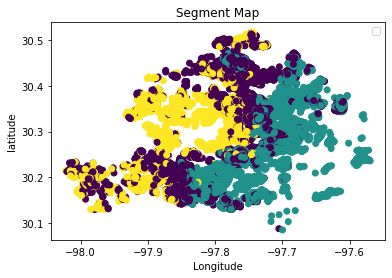

In [25]:
austin=pd.read_csv(data+"/"+'austinHousingData.csv')
try1=austin[['latestPrice','avgSchoolRating','lotSizeSqFt','livingAreaSqFt','numOfBedrooms', 'numOfStories']]
austin=austin.drop(outs)
austin["cluster"]=color
for i in austin["cluster"].unique():
    temp=austin[austin["cluster"]==i]
    #plt.scatter(temp['latitude'],temp['longitude'],label=i)
    med=temp["latestPrice"].median()
    mean=temp["latestPrice"].mean()
    display(f"Cluster {i},Median Price: {med},Mean Price: {mean}")
"""
plt.legend()
plt.show()
"""
plt.scatter(austin['longitude'],austin['latitude'],c=color)
plt.ylabel("latitude")
plt.title(f"Segment Map")
plt.xlabel("Longitude")
plt.legend()
plt.show()

#garbage plotly figure
#fig=px.scatter_geo(austin,lat='latitude',lon='longitude')
#fig.show()
v1=model.inverse_transform(values)
v2=scale.inverse_transform(v1)

#related=pd.DataFrame(v2,columns=try1.columns)
#austin.to_pickle("temp.pkl")

This creates a model with a good gradient from the city center in austin.  It radiates high income out to lower income on the right side.  This proves the validity of the model if one considers the neighboorhoods where houses are similarly priced.  Note that no location data was provided to the model, so this is independent of spatial data.  This goes to create a natural segmentation that follows intuition given that the model is spatially explainable.

## Add in Portland and see if model is stable
(Assumption is that the segmentation persists across cities, check stability in face of new data)

Portland Prep

In [26]:
portland=pd.read_csv(data+"/"+'portland_housing.csv')
portland.columns
[['latestPrice','region_mean','region_median','yearBuilt','avgSchoolRating','lotSizeSqFt','livingAreaSqFt','numOfBedrooms', 'numOfStories']]
portland_abv=pd.DataFrame()
portland_abv[['latestPrice','yearBuilt','avgSchoolRating','zipcode','livingAreaSqFt','lotSizeSqFt','numOfBedrooms', 'numOfStories']]=portland[['price','yearBuilt','schools/0/rating','address/zipcode','livingArea','lotSize','bedrooms','resoFacts/stories']]
portland_abv.describe()

/Users/gregcooper/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (20,50,161,200) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


latestPrice     yearBuilt  avgSchoolRating       zipcode  \
count  2.573100e+04  25185.000000     25706.000000  25731.000000   
mean   5.851917e+05   1975.062140         5.568311  97143.830943   
std    4.518907e+05     54.205158         2.147820    567.759775   
min    3.000000e+02      0.000000         1.000000   7123.000000   
25%    3.910000e+05   1954.000000         4.000000  97062.000000   
50%    5.220000e+05   1981.000000         6.000000  97203.000000   
75%    6.622000e+05   2003.000000         7.000000  97221.000000   
max    4.100000e+07   2021.000000        10.000000  97267.000000   

       livingAreaSqFt   lotSizeSqFt  numOfBedrooms  numOfStories  
count    25266.000000  2.284100e+04   24961.000000  21206.000000  
mean      2179.079237  2.740146e+04       3.356356      1.985429  
std       1129.151916  1.391282e+06       1.001626      0.719863  
min          0.000000  0.000000e+00       0.000000      1.000000  
25%       1460.000000  4.791000e+03       3.000000      1.000000  
50%       1996.000000  6.969000e+03       3.000000      2.000000  
75%       2670.000000  1.001800e+04       4.000000      2.000000  
max      51290.000000  2.087221e+08      43.000000      7.000000

In [27]:
city=portland_abv['zipcode'].unique()
data_city=FHFA.loc[FHFA["zipcode"].isin(city)]
dic={}
for i in data_city["zipcode"].unique():
    subset=data_city[data_city["zipcode"]==i]
    dist=subset.groupby("agi_stub").mean()["N1"]/subset["N1"].sum()
    dic[i]=(subset.groupby("agi_stub").mean()["A00100"]/subset.groupby("agi_stub").mean()["N1"]*dist).sum()
dic2={}
for i in data_city["zipcode"].unique():
    subset=data_city[data_city["zipcode"]==i]
    dist=subset.groupby("agi_stub").mean()["N2"]/subset["N2"].sum()
    dic2[i]=dist[:3].sum()

In [28]:
portland_abv=portland_abv[portland_abv['zipcode'] != 97080]
portland_abv=portland_abv[portland_abv['zipcode'] != 97078]
portland_abv=portland_abv[portland_abv['zipcode'] != 97003]
portland_abv=portland_abv[portland_abv['zipcode'] != 7123]
city=portland_abv['zipcode'].unique()
city
data_city=FHFA.loc[FHFA["zipcode"].isin(city)]
#print(np.setxor1d(data_city['zipcode'].unique(),city))
median_value=dic2
mean_value=dic

fun1=lambda x: mean_value[x]
fun2=lambda x: median_value[x]
portland_abv['expected_return']=portland_abv['zipcode'].apply(fun1)
portland_abv['expected_people']=portland_abv['zipcode'].apply(fun2)
portland_adj=portland_abv.copy()

In [29]:
file=data+"/"+'austinHousingData.csv'
austin=pd.read_csv(file)
pd.options.display.max_columns = None
pd.options.display.max_rows = 10
#try1.head()

Austin Prep

In [30]:
city=austin['zipcode'].unique()
data_city=FHFA.loc[FHFA["zipcode"].isin(city)]
dic={}
for i in data_city["zipcode"].unique():
    subset=data_city[data_city["zipcode"]==i]
    dist=subset.groupby("agi_stub").mean()["N1"]/subset["N1"].sum()
    dic[i]=(subset.groupby("agi_stub").mean()["A00100"]/subset.groupby("agi_stub").mean()["N1"]*dist).sum()
dic2={}
for i in data_city["zipcode"].unique():
    subset=data_city[data_city["zipcode"]==i]
    dist=subset.groupby("agi_stub").mean()["N2"]/subset["N2"].sum()
    dic2[i]=dist[:3].sum()

In [31]:
city=austin['zipcode'].unique()
data_city=FHFA.loc[FHFA["zipcode"].isin(city)]
median_value=dic2
mean_value=dic
fun1=lambda x: mean_value[x]
fun2=lambda x: median_value[x]
austin['expected_return']=austin['zipcode'].apply(fun1)
austin['expected_people']=austin['zipcode'].apply(fun2)
austin_adj=austin.copy()

Merge and preform simple naive clustering on both to test naive stability

In [32]:
values=StandardScaler().fit_transform(portland_adj)
portland_adj=pd.DataFrame(values,columns=portland_adj.columns)

In [33]:
try1=austin[['latestPrice','expected_return','expected_people','yearBuilt','avgSchoolRating','lotSizeSqFt','livingAreaSqFt','numOfBedrooms', 'numOfStories']]
try1=StandardScaler().fit_transform(try1)
austin_adj=pd.DataFrame(try1,columns=['latestPrice','expected_return','expected_people','yearBuilt','avgSchoolRating','lotSizeSqFt','livingAreaSqFt','numOfBedrooms', 'numOfStories'])

In [34]:
portland_adj

latestPrice  yearBuilt  avgSchoolRating   zipcode  livingAreaSqFt  \
0        -0.605159   0.591155        -0.283622 -1.509739       -0.343803   
1        -0.422066   0.483285        -0.283622 -1.509739       -0.594082   
2        -0.534605  -0.379676        -1.672454  0.900896       -0.855657   
3        -0.184001  -0.127979        -1.672454 -1.439527        0.172396   
4        -0.252823   0.069783        -0.283622 -1.439527       -0.143928   
...            ...        ...              ...       ...             ...   
24104    -0.389602   0.051804         0.642267 -1.696973       -0.715745   
24105     0.043242  -0.002131        -1.209510 -1.708675       -0.022265   
24106    -0.465350   0.483285        -0.283622 -1.696973       -0.639271   
24107    -1.162236  -0.972961         0.179323  0.818981       -0.653175   
24108    -0.021685  -0.271806         0.179323  0.818981        0.359235   

       lotSizeSqFt  numOfBedrooms  numOfStories  expected_return  \
0        -0.018289      -0.350871           NaN        -0.979141   
1        -0.016948      -0.350871      0.001529        -0.979141   
2        -0.009677      -0.350871     -1.379688        -1.065872   
3        -0.013428       2.597356           NaN        -1.131154   
4        -0.014524      -0.350871           NaN        -1.131154   
...            ...            ...           ...              ...   
24104    -0.012404      -0.350871     -1.379688        -0.502513   
24105    -0.012706       0.631871      1.382746         0.131835   
24106    -0.018159      -1.333614      0.001529        -0.502513   
24107    -0.006951      -0.350871           NaN        -0.287280   
24108    -0.008465       0.631871      0.001529        -0.287280   

       expected_people  
0             1.546385  
1             1.546385  
2             1.509287  
3             1.589746  
4             1.589746  
...                ...  
24104         0.413543  
24105        -0.626108  
24106         0.413543  
24107        -0.063289  
24108        -0.063289  

[24109 rows x 10 columns]

In [35]:
combo=pd.concat([portland_adj,austin_adj])
combo.pop("zipcode")
combo

latestPrice  yearBuilt  avgSchoolRating  livingAreaSqFt  lotSizeSqFt  \
0        -0.605159   0.591155        -0.283622       -0.343803    -0.018289   
1        -0.422066   0.483285        -0.283622       -0.594082    -0.016948   
2        -0.534605  -0.379676        -1.672454       -0.855657    -0.009677   
3        -0.184001  -0.127979        -1.672454        0.172396    -0.013428   
4        -0.252823   0.069783        -0.283622       -0.143928    -0.014524   
...            ...        ...              ...             ...          ...   
15166    -0.403309  -0.118392        -1.315213       -0.706784    -0.009186   
15167     0.082160   1.271865         0.476695       -0.232366    -0.009520   
15168     0.799329  -2.435486        -0.419259       -0.496415    -0.008951   
15169    -0.204708  -0.952546         0.476695        2.799848    -0.009222   
15170    -0.304229  -1.554990         0.476695       -1.079645    -0.009293   

       numOfBedrooms  numOfStories  expected_return  expected_people  
0          -0.350871           NaN        -0.979141         1.546385  
1          -0.350871      0.001529        -0.979141         1.546385  
2          -0.350871     -1.379688        -1.065872         1.509287  
3           2.597356           NaN        -1.131154         1.589746  
4          -0.350871           NaN        -1.131154         1.589746  
...              ...           ...              ...              ...  
15166      -0.518146     -0.892288        -0.567286         0.337264  
15167      -0.518146      2.926841        -0.756547         1.554237  
15168      -0.518146      1.017276        -0.009802         0.108980  
15169       0.658444     -0.892288        -0.399012         0.088822  
15170      -1.694736     -0.892288        -0.379346         0.681504  

[39280 rows x 9 columns]

Varaince ratios
[0.40611527 0.15658339]
0.00043279022403258654


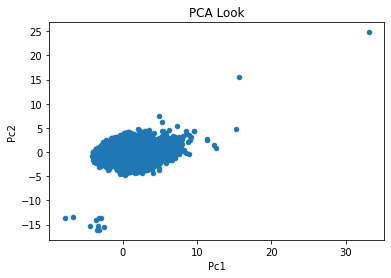

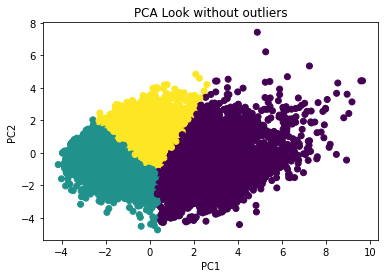

latestPrice  yearBuilt  avgSchoolRating  livingAreaSqFt  lotSizeSqFt  \
0        -0.422066   0.483285        -0.283622       -0.594082    -0.016948   
1        -0.534605  -0.379676        -1.672454       -0.855657    -0.009677   
2        -0.465350  -0.110001        -0.746566       -0.828717    -0.013918   
3        -0.573561  -0.092022        -1.672454       -0.793957    -0.013009   
4        -0.450200  -0.217871        -0.746566       -0.759196    -0.014524   
...            ...        ...              ...             ...          ...   
32767    -0.403309  -0.118392        -1.315213       -0.706784    -0.009186   
32768     0.082160   1.271865         0.476695       -0.232366    -0.009520   
32769     0.799329  -2.435486        -0.419259       -0.496415    -0.008951   
32770    -0.204708  -0.952546         0.476695        2.799848    -0.009222   
32771    -0.304229  -1.554990         0.476695       -1.079645    -0.009293   

       numOfBedrooms  numOfStories  expected_return  expected_people  cluster  \
0          -0.350871      0.001529        -0.979141         1.546385        1   
1          -0.350871     -1.379688        -1.065872         1.509287        1   
2          -0.350871     -1.379688        -1.386119         2.348815        1   
3          -0.350871     -1.379688        -1.131154         1.589746        1   
4          -0.350871     -1.379688        -1.065872         1.509287        1   
...              ...           ...              ...              ...      ...   
32767      -0.518146     -0.892288        -0.567286         0.337264        1   
32768      -0.518146      2.926841        -0.756547         1.554237        2   
32769      -0.518146      1.017276        -0.009802         0.108980        1   
32770       0.658444     -0.892288        -0.399012         0.088822        2   
32771      -1.694736     -0.892288        -0.379346         0.681504        1   

            pc1       pc2  
0     -1.745396  0.774638  
1     -2.937607  0.144996  
2     -3.029265  0.393948  
3     -2.954321  0.330615  
4     -2.482495 -0.033476  
...         ...       ...  
32767 -1.821517 -0.237119  
32768 -0.220622  2.192692  
32769 -0.449894 -0.720073  
32770  0.754285  0.367023  
32771 -1.838423 -1.919199  

[32772 rows x 12 columns]

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
try1=combo
try1=try1.dropna()
try1=try1.reset_index(drop=True)
major=10
n_clusters=3
#scale=StandardScaler().fit(try1)
#try2=scale.transform(try1)
try2=try1
model=PCA(n_components=2).fit(try2)
print("Varaince ratios")
print(model.explained_variance_ratio_)
values=model.transform(try2)
principalDf = pd.DataFrame(data = values
             , columns = ['pc1', 'pc2'])
outlier_pc1=principalDf[principalDf['pc1'] > major].index
outlier_pc2=principalDf[principalDf['pc2'] > major].index
outlier_pc3=principalDf[principalDf['pc1'] < -major].index
outlier_pc4=principalDf[principalDf['pc2'] < -major].index
outs=outlier_pc1.union(outlier_pc2)
outs=outs.union(outlier_pc3)
outs=outs.union(outlier_pc4)
print(len(outs)/len(combo))
new=try1.drop(outs)
#try2=scale.transform(new)
values=model.transform(new)
principalDf[['pc1',
       'pc2',]].plot.scatter(x='pc1',y='pc2',title="PCA Look",ylabel="Pc2",xlabel="Pc1")
principalDf = pd.DataFrame(data = values
             , columns = ['pc1', 'pc2'])
plt.show()
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(principalDf)
color=np.array(kmeans.labels_)
try1=try1.drop(outs)
try1=try1.reset_index(drop=True)
try1["cluster"]=color
whole=pd.concat([try1,principalDf],axis=1)
plt.scatter(whole['pc1'],whole['pc2'],c=whole['cluster'])
plt.ylabel("PC2")
plt.xlabel("PC1")
plt.title("PCA Look without outliers")
plt.show()
whole

'Cluster 2,Median Price: 459950.0,Mean Price: 549277.7541040867'

'Cluster 0,Median Price: 389900.0,Mean Price: 727444.1491745283'

'Cluster 1,Median Price: 349000.0,Mean Price: 374070.3096602538'

No handles with labels found to put in legend.


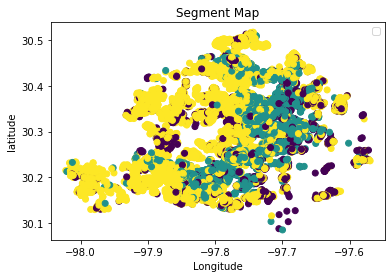

In [40]:

try1=austin[['latestPrice','expected_return','expected_people','yearBuilt','avgSchoolRating','lotSizeSqFt','livingAreaSqFt','numOfBedrooms', 'numOfStories']]
#try1=try1.drop(['latestPrice','region_mean','region_median'],axis=1)
v1=StandardScaler().fit_transform(try1)
v2=model.transform(v1)
austin["cluster"]=kmeans.predict(v2)
color=kmeans.predict(v2)
for i in austin["cluster"].unique():
    temp=austin[austin["cluster"]==i]
    #plt.scatter(temp['latitude'],temp['longitude'],label=i)
    med=temp["latestPrice"].median()
    mean=temp["latestPrice"].mean()
    display(f"Cluster {i},Median Price: {med},Mean Price: {mean}")

"""
plt.legend()
plt.show()
"""
plt.scatter(austin['longitude'],austin['latitude'],c=color)
plt.ylabel("latitude")
plt.title(f"Segment Map")
plt.xlabel("Longitude")
plt.legend()
plt.show()
#fig=px.scatter_geo(austin,lat='latitude',lon='longitude')
#fig.show()
v1=model.inverse_transform(values)
v2=scale.inverse_transform(v1)

17618


/Users/gregcooper/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (20,50,161,200) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


'Cluster 2,Median Price: 605000.0,Mean Price: 694093.8348486592'

'Cluster 1,Median Price: 500000.0,Mean Price: 522864.6825585543'

'Cluster 0,Median Price: 677500.0,Mean Price: 990820.3532818533'

No handles with labels found to put in legend.


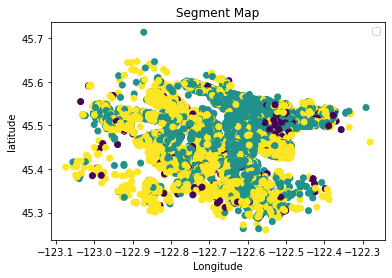

In [43]:
portland=pd.read_csv(data+"/"+'portland_housing.csv')
try1=portland_abv.copy()
#try1=try1.drop(['latestPrice','region_mean','region_median'],axis=1)
try1.pop("zipcode")
try1=try1[['latestPrice', 'expected_return', 'expected_people', 'yearBuilt','avgSchoolRating', 'lotSizeSqFt', 'livingAreaSqFt', 'numOfBedrooms','numOfStories']]
try1=try1.dropna()
v1=scale.transform(try1)
v2=model.transform(v1)
print(len(v2))
portland=portland.iloc[try1.index]
portland['cluster']=kmeans.predict(v2)
color=kmeans.predict(v2)
for i in portland["cluster"].unique():
    temp=portland[portland["cluster"]==i]
    #plt.scatter(temp['latitude'],temp['longitude'],label=i)
    med=temp['priceHistory/0/price'].median()
    mean=temp['priceHistory/0/price'].mean()
    display(f"Cluster {i},Median Price: {med},Mean Price: {mean}")
plt.scatter(portland['longitude'],portland['latitude'],c=color)
plt.ylabel("latitude")
plt.title(f"Segment Map")
plt.xlabel("Longitude")
plt.legend()
plt.show()

Note that the segmentation somewhat works, but is not nearly as clean a gradient as required, using price again as guiding metric

## Price guided model
Used for our further purposes, it provides better segmentation

In [50]:
portland=pd.read_csv(data+"/"+'portland_housing.csv')
portland.columns
[['latestPrice','region_mean','region_median','yearBuilt','avgSchoolRating','lotSizeSqFt','livingAreaSqFt','numOfBedrooms', 'numOfStories']]
portland_abv=pd.DataFrame()
portland_abv[['latestPrice','yearBuilt','avgSchoolRating','zipcode','livingAreaSqFt','lotSizeSqFt','numOfBedrooms', 'numOfStories',"latitude","longitude"]]=portland[['price','yearBuilt','schools/0/rating','address/zipcode','livingArea','lotSize','bedrooms','resoFacts/stories',"latitude","longitude"]]
portland_abv.describe()
city=portland_abv['zipcode'].unique()
data_city=FHFA.loc[FHFA["zipcode"].isin(city)]
dic={}
for i in data_city["zipcode"].unique():
    subset=data_city[data_city["zipcode"]==i]
    dist=subset.groupby("agi_stub").mean()["N1"]/subset["N1"].sum()
    dic[i]=(subset.groupby("agi_stub").mean()["A00100"]/subset.groupby("agi_stub").mean()["N1"]*dist).sum()
dic2={}
for i in data_city["zipcode"].unique():
    subset=data_city[data_city["zipcode"]==i]
    dist=subset.groupby("agi_stub").mean()["N2"]/subset["N2"].sum()
    dic2[i]=dist[:3].sum()
portland_abv=portland_abv[portland_abv['zipcode'] != 97080]
portland_abv=portland_abv[portland_abv['zipcode'] != 97078]
portland_abv=portland_abv[portland_abv['zipcode'] != 97003]
portland_abv=portland_abv[portland_abv['zipcode'] != 7123]
city=portland_abv['zipcode'].unique()
city
data_city=FHFA.loc[FHFA["zipcode"].isin(city)]
#print(np.setxor1d(data_city['zipcode'].unique(),city))
median_value=dic2
mean_value=dic
fun1=lambda x: mean_value[x]
fun2=lambda x: median_value[x]
portland_abv['expected_return']=portland_abv['zipcode'].apply(fun1)
portland_abv['expected_people']=portland_abv['zipcode'].apply(fun2)
portland_adj=portland_abv.copy()
file=data+"/"+'austinHousingData.csv'
austin=pd.read_csv(file)
austin_locations=austin[["longitude",'latitude']]
pd.options.display.max_columns = None
pd.options.display.max_rows = 10
#try1.head()
city=austin['zipcode'].unique()
data_city=FHFA.loc[FHFA["zipcode"].isin(city)]
dic={}
for i in data_city["zipcode"].unique():
    subset=data_city[data_city["zipcode"]==i]
    dist=subset.groupby("agi_stub").mean()["N1"]/subset["N1"].sum()
    dic[i]=(subset.groupby("agi_stub").mean()["A00100"]/subset.groupby("agi_stub").mean()["N1"]*dist).sum()
dic2={}
for i in data_city["zipcode"].unique():
    subset=data_city[data_city["zipcode"]==i]
    dist=subset.groupby("agi_stub").mean()["N2"]/subset["N2"].sum()
    dic2[i]=dist[:3].sum()
city=austin['zipcode'].unique()
data_city=FHFA.loc[FHFA["zipcode"].isin(city)]
median_value=dic2
mean_value=dic
fun1=lambda x: mean_value[x]
fun2=lambda x: median_value[x]
austin['expected_return']=austin['zipcode'].apply(fun1)
austin['expected_people']=austin['zipcode'].apply(fun2)
austin_adj=austin.copy()
portland_locations=portland_abv[['longitude','latitude']]
#portland_adj["latestPrice"]=portland_adj["latestPrice"]/1.5
temp1=portland_adj.drop("zipcode",axis=1)
portland_adj=StandardScaler().fit_transform(temp1)
portland_adj=pd.DataFrame(portland_adj,columns=temp1.columns)
portland_adj=portland_adj[['latestPrice','expected_return','expected_people','yearBuilt','avgSchoolRating','lotSizeSqFt','livingAreaSqFt','numOfBedrooms', 'numOfStories']]
try1=austin[['latestPrice','expected_return','expected_people','yearBuilt','avgSchoolRating','lotSizeSqFt','livingAreaSqFt','numOfBedrooms', 'numOfStories']]
try1=StandardScaler().fit_transform(try1)
austin_adj=pd.DataFrame(try1,columns=['latestPrice','expected_return','expected_people','yearBuilt','avgSchoolRating','lotSizeSqFt','livingAreaSqFt','numOfBedrooms', 'numOfStories'])
combo=pd.concat([portland_adj,austin_adj])
combo_locations=pd.concat([portland_locations,austin_locations])
combo

/Users/gregcooper/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (20,50,161,200) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


latestPrice  expected_return  expected_people  yearBuilt  \
0        -0.605159        -0.979141         1.546385   0.591155   
1        -0.422066        -0.979141         1.546385   0.483285   
2        -0.534605        -1.065872         1.509287  -0.379676   
3        -0.184001        -1.131154         1.589746  -0.127979   
4        -0.252823        -1.131154         1.589746   0.069783   
...            ...              ...              ...        ...   
15166    -0.403309        -0.567286         0.337264  -0.118392   
15167     0.082160        -0.756547         1.554237   1.271865   
15168     0.799329        -0.009802         0.108980  -2.435486   
15169    -0.204708        -0.399012         0.088822  -0.952546   
15170    -0.304229        -0.379346         0.681504  -1.554990   

       avgSchoolRating  lotSizeSqFt  livingAreaSqFt  numOfBedrooms  \
0            -0.283622    -0.018289       -0.343803      -0.350871   
1            -0.283622    -0.016948       -0.594082      -0.350871   
2            -1.672454    -0.009677       -0.855657      -0.350871   
3            -1.672454    -0.013428        0.172396       2.597356   
4            -0.283622    -0.014524       -0.143928      -0.350871   
...                ...          ...             ...            ...   
15166        -1.315213    -0.009186       -0.706784      -0.518146   
15167         0.476695    -0.009520       -0.232366      -0.518146   
15168        -0.419259    -0.008951       -0.496415      -0.518146   
15169         0.476695    -0.009222        2.799848       0.658444   
15170         0.476695    -0.009293       -1.079645      -1.694736   

       numOfStories  
0               NaN  
1          0.001529  
2         -1.379688  
3               NaN  
4               NaN  
...             ...  
15166     -0.892288  
15167      2.926841  
15168      1.017276  
15169     -0.892288  
15170     -0.892288  

[39280 rows x 9 columns]

variance ratios of total set [0.40611527 0.15658339 0.12077663 0.08406638 0.06829298 0.0579596
 0.05178622]


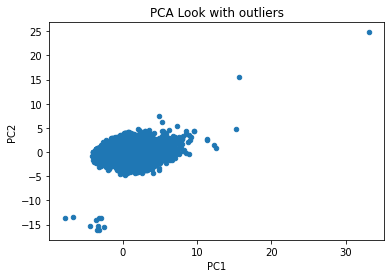

dropped outliers at % 0.04837067209775967
0.0004837067209775967


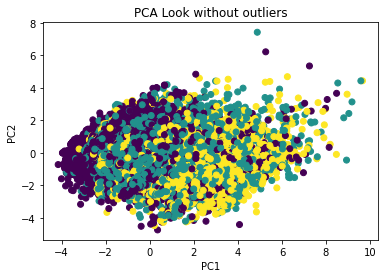

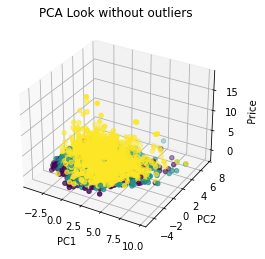

pc1


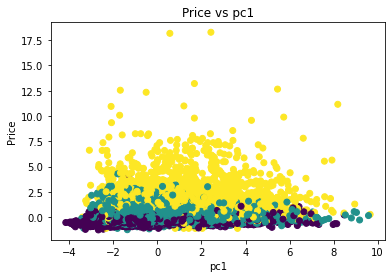

pc3


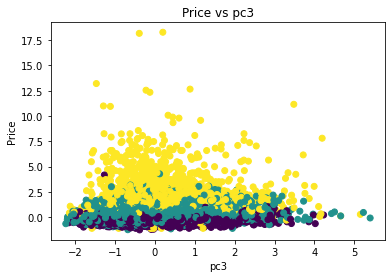

pc4


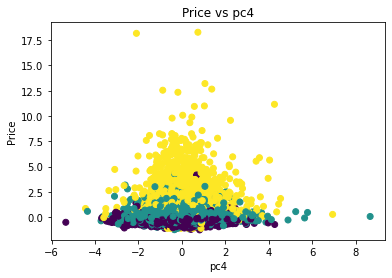

pc6


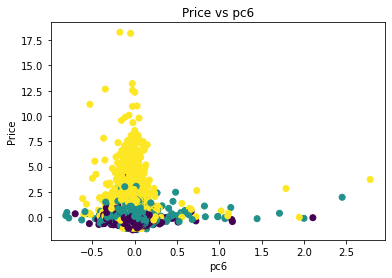

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
combo=combo.reset_index(drop=True)
combo_locations=combo_locations.reset_index(drop=False)
try1=combo
try1=try1.dropna()
indexs=try1.index
combo_locations=combo_locations.iloc[indexs]
major=10
n_clusters=3
#scale=StandardScaler().fit(try1)
#try2=scale.transform(try1)
try2=try1
model=PCA(n_components=7).fit(try2)
print("variance ratios of total set" , model.explained_variance_ratio_)
values=model.transform(try2)
principalDf = pd.DataFrame(data = values
             , columns = ['pc1', 'pc2',"pc3","pc4",'pc5','pc6','pc7'])
principalDf[['pc1',
       'pc2',]].plot.scatter(x='pc1',y='pc2')
plt.ylabel("PC2")
plt.xlabel("PC1")
plt.title("PCA Look with outliers")
plt.show()
outlier_pc1=principalDf[principalDf['pc1'] > major].index
outlier_pc2=principalDf[principalDf['pc2'] > major].index
outlier_pc3=principalDf[principalDf['pc3'] > major].index
outlier_pc4=principalDf[principalDf['pc6'] > major].index
outs=outlier_pc1.union(outlier_pc2)
outs=outs.union(outlier_pc3)
outs=outs.union(outlier_pc4)
print("dropped outliers at %" , 100*(len(outs)/len(combo)))
try2=try2.reset_index(drop=True)
combo_locations=combo_locations.reset_index(drop=True)
new=try2.drop(outs)
indexs=new.index
combo_locations=combo_locations.iloc[indexs]
print(len(outs)/len(combo))
values=model.transform(new)
principalDf = pd.DataFrame(data = values
             , columns = ['pc1', 'pc2',"pc3","pc4",'pc5','pc6','pc7'])
new_df=principalDf[["pc1",'pc3',"pc4",'pc6']]
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(new_df)
color=np.array(kmeans.labels_)
new["cluster"]=color
combo_locations["cluster"]=color
whole=pd.concat([new,principalDf],axis=1)
plt.scatter(whole['pc1'],whole['pc2'],c=whole['cluster'])
plt.ylabel("PC2")
plt.xlabel("PC1")
plt.title("PCA Look without outliers")
plt.show()
ax = plt.axes(projection='3d')
plt.ylabel("PC2")
plt.xlabel("PC1")
ax.set_zlabel('Price')
plt.title("PCA Look without outliers")
# Data for a three-dimensional line
ax.scatter(whole['pc1'], whole['pc2'], whole["latestPrice"], c=whole['cluster'])
plt.show()
for i in new_df.columns:
       print(i)
       plt.scatter(whole[i],whole['latestPrice'],c=whole['cluster'])
       plt.ylabel("Price")
       plt.title(f"Price vs {i}")
       plt.xlabel(i)
       plt.show()

Once again, segmented well on price

In [52]:
austin_back=combo_locations[combo_locations["latitude"]<40]
a_b=austin_back.set_index("index")

'Cluster 1,Median Price: 425000.0,Mean Price: 484795.73560538114'

'Cluster 0,Median Price: 325000.0,Mean Price: 342584.3351581509'

'Cluster 2,Median Price: 699000.0,Mean Price: 917565.4251576501'

No handles with labels found to put in legend.


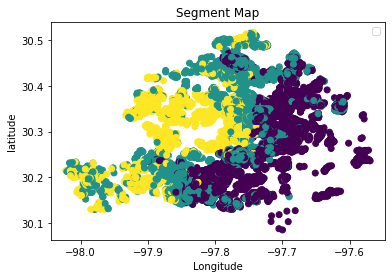

In [53]:
austin=austin.join(a_b,how="inner",rsuffix='None')
for i in austin["cluster"].unique():
    temp=austin[austin["cluster"]==i]
    #plt.scatter(temp['longitude'],temp['latitude'],label=i)
    med=temp["latestPrice"].median()
    mean=temp["latestPrice"].mean()
    display(f"Cluster {i},Median Price: {med},Mean Price: {mean}")
plt.ylabel("latitude")
plt.title(f"Segment Map")
plt.xlabel("Longitude")
plt.scatter(austin['longitude'],austin['latitude'],c=austin["cluster"])
plt.legend()
plt.show()

In [55]:
portland_back=combo_locations[combo_locations["latitude"]>40]
p_b=portland_back.set_index("index")

'Cluster 0,Median Price: 433310.0,Mean Price: 445929.0683290156'

'Cluster 1,Median Price: 575000.0,Mean Price: 598053.426348808'

'Cluster 2,Median Price: 870000.0,Mean Price: 1025343.1725137722'

No handles with labels found to put in legend.


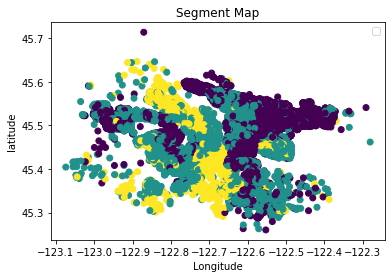

In [56]:
portland=portland.join(p_b,how="inner",rsuffix='None')
for i in portland["cluster"].unique():
    temp=portland[portland["cluster"]==i]
    #plt.scatter(temp['longitude'],temp['latitude'],label=i)
    med=temp["price"].median()
    mean=temp["price"].mean()
    display(f"Cluster {i},Median Price: {med},Mean Price: {mean}")
plt.scatter(portland['longitude'],portland['latitude'],c=portland["cluster"])
plt.legend()
plt.ylabel("latitude")
plt.title(f"Segment Map")
plt.xlabel("Longitude")
plt.show()

Far cleaner gradient that maintaints relationships wanted (austin city center, portland high income by water), development furthered by this model

In [57]:
austin.to_pickle("Austin_3_cluster.pkl")
portland.to_pickle("portland_3_cluster.pkl")

#### TASK 2 Decompose HPI from model for regression

In [58]:
import pandas as pd
import numpy as np
import os

Process model data and make import relevent outside income data

In [59]:
path=os.getcwd()
time=path+"//Time"
austin=pd.read_pickle("Austin_3_cluster.pkl")

In [60]:

paths=os.listdir(time)

In [61]:
dic={}
for count,i in enumerate(paths):
    dic[count]=pd.read_csv(time+"/"+i)

In [62]:
dic2={}
for i in dic:
    dic2[i]=dic[i].loc[dic[i]['RegionName'].isin(austin['zipcode'].unique())]

Select sample size of 300+ house zip codes

In [63]:
z=austin.groupby('zipcode')
lots=z.filter(lambda x: x['city'].count()>300)['zipcode'].unique()
v=[]
for i in dic2:
    valids=dic2[i].loc[dic2[i]['RegionName'].isin(lots)]['RegionName'].unique()
    v.extend(valids)

Get counts for weighted average

In [64]:
from collections import Counter
check=Counter(v)
t_v=[i for i in check if (check[i] ==5)]
a=austin.loc[austin['zipcode'].isin(t_v)]
#values maybe?
"""
    a=a[a['zipcode'] != 78757]
    a=a[a['zipcode'] != 78758]
    a=a[a['zipcode'] != 78723]
"""
a=a[(a['numOfBedrooms'] <=5) & (a['numOfBedrooms'] > 0)]

broken=a.groupby(['zipcode',"cluster",'numOfBedrooms'])
easier={}
for t,b in broken:
    easier[t]=len(b)
easier

{(78702, 0, 1): 20,
 (78702, 0, 2): 105,
 (78702, 0, 3): 128,
 (78702, 0, 4): 26,
 (78702, 0, 5): 1,
 (78702, 1, 1): 1,
 (78702, 1, 2): 9,
 (78702, 1, 3): 67,
 (78702, 1, 4): 28,
 (78702, 1, 5): 4,
 (78703, 1, 1): 3,
 (78703, 1, 2): 40,
 (78703, 1, 3): 21,
 (78703, 2, 2): 5,
 (78703, 2, 3): 95,
 (78703, 2, 4): 96,
 (78703, 2, 5): 30,
 (78704, 0, 1): 18,
 (78704, 0, 2): 100,
 (78704, 0, 3): 145,
 (78704, 0, 4): 16,
 (78704, 1, 2): 42,
 (78704, 1, 3): 181,
 (78704, 1, 4): 143,
 (78704, 1, 5): 10,
 (78704, 2, 3): 1,
 (78704, 2, 4): 30,
 (78704, 2, 5): 14,
 (78723, 0, 1): 1,
 (78723, 0, 2): 32,
 (78723, 0, 3): 308,
 (78723, 0, 4): 108,
 (78723, 0, 5): 5,
 (78723, 1, 2): 10,
 (78723, 1, 3): 50,
 (78723, 1, 4): 35,
 (78723, 1, 5): 6,
 (78731, 1, 1): 3,
 (78731, 1, 2): 46,
 (78731, 1, 3): 157,
 (78731, 1, 4): 32,
 (78731, 2, 2): 1,
 (78731, 2, 3): 26,
 (78731, 2, 4): 165,
 (78731, 2, 5): 57,
 (78745, 0, 1): 4,
 (78745, 0, 2): 59,
 (78745, 0, 3): 715,
 (78745, 0, 4): 163,
 (78745, 0, 5): 10,
 

Using assumption that the cluster are a linear combination of bedrooms found in each house, process and decompose HPI by cluster and zip

In [65]:
import datetime
overall={}
sum_counter=0
time_series={
   1:[],
   2:[],
   3:[],
   4:[],
   5:[],
}
t_s=time_series.copy()
early=datetime.datetime.strptime("2000 1 1", '%Y %m %d')
net_series=pd.DataFrame()
active=[]
t_cluster=0
final_holder={}
t_zip=78702
for i in easier:
   zipcode,cluster,bedroom=i
   print(cluster,bedroom,zipcode)
   if cluster != t_cluster or zipcode != t_zip:
      print("run")
      for act in (active):
         _,_,c_t=act
         scale=easier[act]/sum_counter
         #print(act,c_t)
         #print(net_series,scale)
         if len(net_series) == 0:
            net_series=t_s[c_t] * scale
         else:
            #print(c_t)
            temp_series=t_s[c_t] * scale
            net_series=pd.concat([net_series,temp_series],axis=1)
      print(zipcode,cluster)
      final_holder[(t_zip,t_cluster)]=net_series
      net_series=pd.DataFrame()
      active=[]
      t_s=time_series.copy()
   if zipcode != t_zip:
         print("yes")
         t_s=time_series.copy()
         early=datetime.datetime.strptime("2000 1 1", '%Y %m %d')
   series=dic2[bedroom-1][dic2[bedroom-1]["RegionName"]==zipcode]
   series=series.drop(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName',],axis=1)
   series=series.dropna(axis=1)
   t_s[bedroom]=series.T.pct_change()
   if datetime.datetime.strptime(series.columns[0].replace("-"," "), '%Y %m %d') > early:
      early=datetime.datetime.strptime(series.columns[0].replace("-"," "), '%Y %m %d')
      holder=(series,zipcode)
   time_series[bedroom]
   sum_counter+=easier[i]
   active.append(i)
   t_zip=zipcode
   t_cluster=cluster

0 1 78702
0 2 78702
0 3 78702
0 4 78702
0 5 78702
1 1 78702
run
78702 1
1 2 78702
1 3 78702
1 4 78702
1 5 78702
1 1 78703
run
78703 1
yes
1 2 78703
1 3 78703
2 2 78703
run
78703 2
2 3 78703
2 4 78703
2 5 78703
0 1 78704
run
78704 0
yes
0 2 78704
0 3 78704
0 4 78704
1 2 78704
run
78704 1
1 3 78704
1 4 78704
1 5 78704
2 3 78704
run
78704 2
2 4 78704
2 5 78704
0 1 78723
run
78723 0
yes
0 2 78723
0 3 78723
0 4 78723
0 5 78723
1 2 78723
run
78723 1
1 3 78723
1 4 78723
1 5 78723
1 1 78731
run
78731 1
yes
1 2 78731
1 3 78731
1 4 78731
2 2 78731
run
78731 2
2 3 78731
2 4 78731
2 5 78731
0 1 78745
run
78745 0
yes
0 2 78745
0 3 78745
0 4 78745
0 5 78745
1 3 78745
run
78745 1
1 4 78745
1 5 78745
0 1 78757
run
78757 0
yes
0 2 78757
0 3 78757
0 4 78757
1 2 78757
run
78757 1
1 3 78757
1 4 78757
1 5 78757
2 4 78757
run
78757 2
2 5 78757
0 1 78758
run
78758 0
yes
0 2 78758
0 3 78758
0 4 78758
0 5 78758
1 2 78758
run
78758 1
1 3 78758
1 4 78758
1 5 78758
0 2 78759
run
78759 0
yes
0 3 78759
1 2 78759
ru

Check zips and clusters in each

In [66]:
final_holder.keys()

dict_keys([(78702, 0), (78702, 1), (78703, 1), (78703, 2), (78704, 0), (78704, 1), (78704, 2), (78723, 0), (78723, 1), (78731, 1), (78731, 2), (78745, 0), (78745, 1), (78757, 0), (78757, 1), (78757, 2), (78758, 0), (78758, 1), (78759, 0), (78759, 1)])

Show percent changes for each of these values

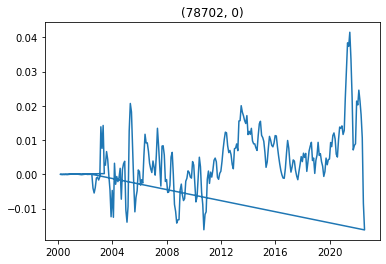

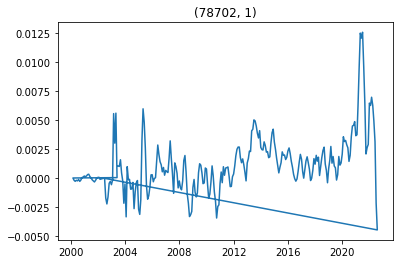

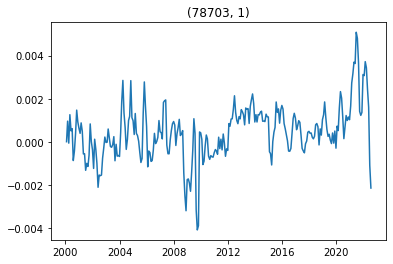

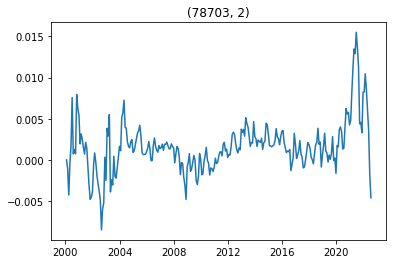

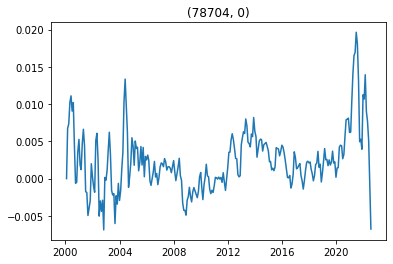

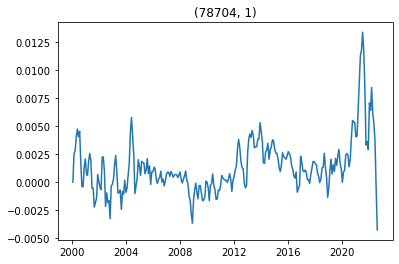

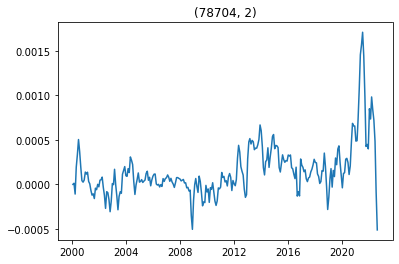

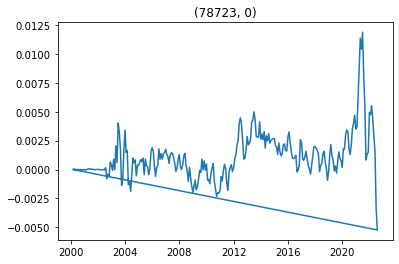

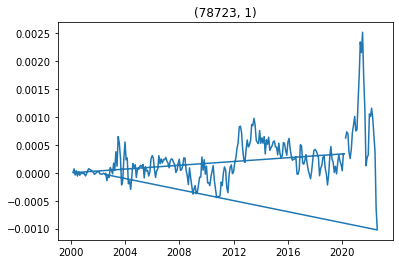

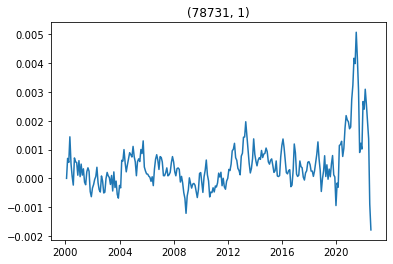

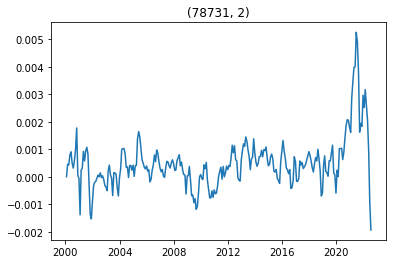

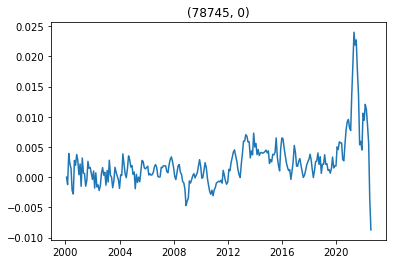

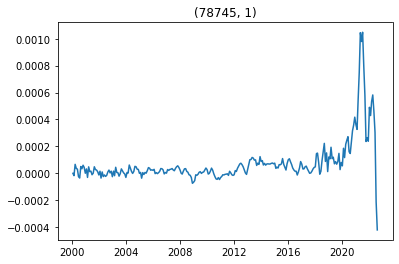

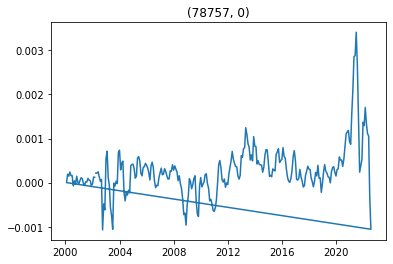

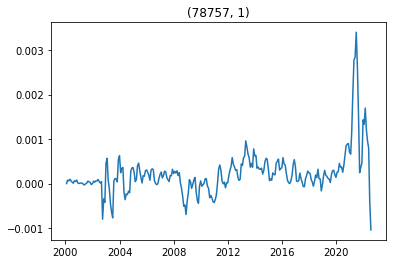

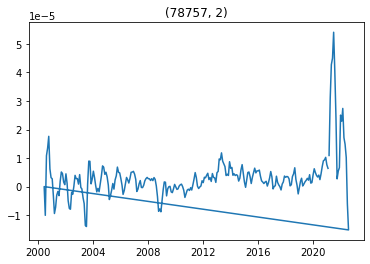

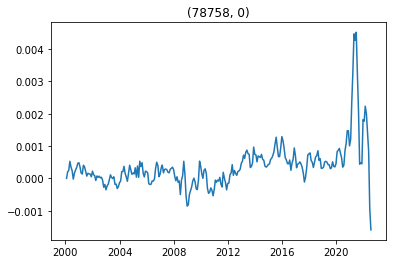

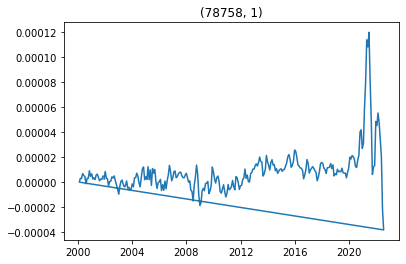

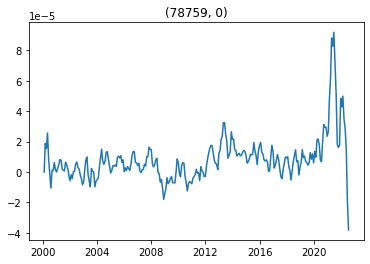

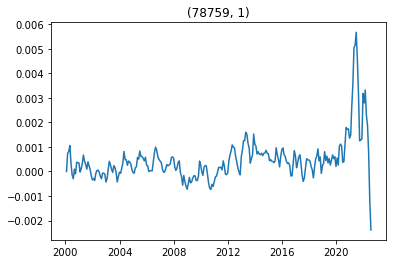

In [68]:
import matplotlib.pyplot as plt
for a in final_holder:
    z=final_holder[a]
    plt.plot(pd.to_datetime(z.index),z[z.columns].sum(axis=1))
    plt.title(a)
    plt.show()

Show scatter plot of the points to show how the aggregated data will be weighted (NA show as - here so disregard the lines at 0)

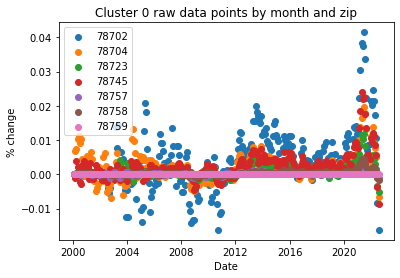

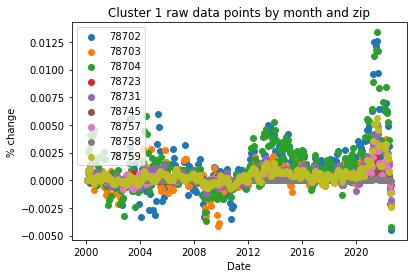

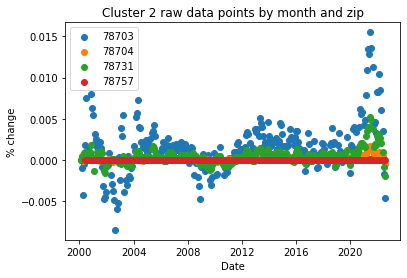

In [74]:
for x in range(3):
    zeros=[final_holder[i] for i in final_holder if i[1] == x]
    zeros_z=[i[0] for i in final_holder if i[1] == x]
    for a,b in zip(zeros,zeros_z):
        plt.scatter(pd.to_datetime(a.index),a[a.columns].sum(axis=1),label=b)
        plt.ylabel("% change")
        plt.xlabel("Date")
    plt.title(f"Cluster {x} raw data points by month and zip")
    plt.legend()
    plt.show()

Aggregate data (evenly per zipcode)

In [75]:
def weight(x):
    x=x.dropna()
    x=x.sum()/len(x)
    return x

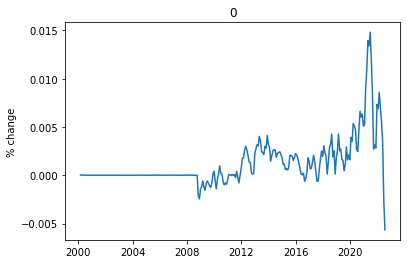

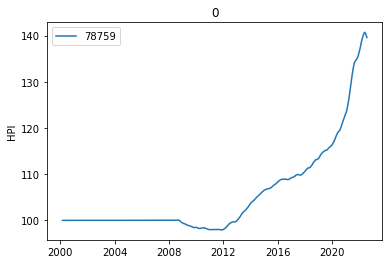

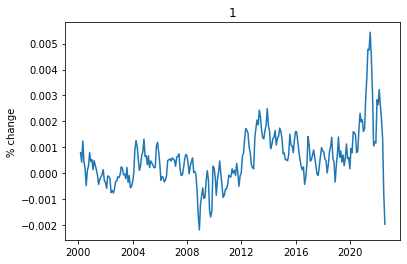

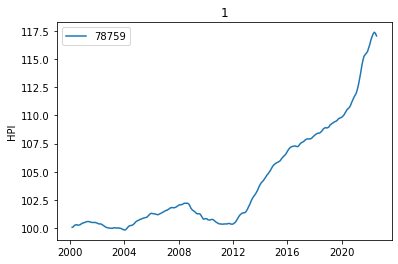

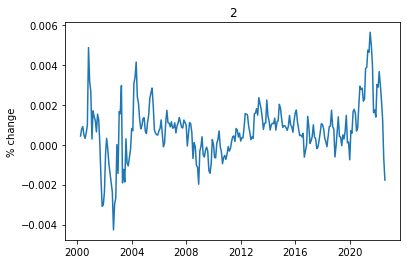

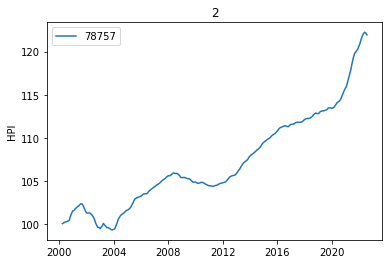

In [76]:
output={}
for x in range(3):
    zeros=[final_holder[i] for i in final_holder if i[1] == x]
    zeros_z=[i[0] for i in final_holder if i[1] == x]
    mega=pd.DataFrame()
    for a,b in zip(zeros,zeros_z):
        a=a.dropna(how="any")
        temp=a[a.columns].sum(axis=1)
        mega=pd.concat([mega,temp],axis=1)
    mega.index = pd.to_datetime(mega.index)
    mega=mega.sort_index()
    mega["weighted"]=mega.apply(weight,axis=1)
    base=100
    HPI=[]
    for i in mega["weighted"]:
        HPI.append(base*(1+i))
        base=base*(1+i)
    output[x]=[HPI,mega["weighted"]]
    plt.plot(mega.index,mega["weighted"],label=b)
    plt.ylabel("% change")
    plt.title(x)
    plt.show()
    plt.plot(mega.index,HPI,label=b)
    plt.ylabel("HPI")
    plt.title(x)
    plt.legend()
    plt.show()

HPI decomposed

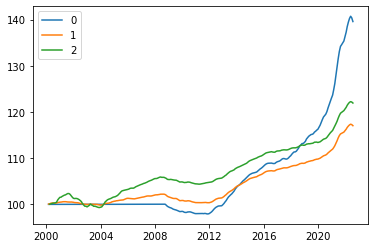

In [77]:
for i in output:
    plt.plot(output[i][1].index,output[i][0],label=i)
plt.legend()

#### Repeast Process for portland
(not commented)

In [78]:
path=os.getcwd()
time=path+"//Time"
austin=pd.read_pickle("portland_3_cluster.pkl")

In [79]:

paths=os.listdir(time)

In [80]:
dic={}
for count,i in enumerate(paths):
    dic[count]=pd.read_csv(time+"/"+i)

In [81]:
dic2={}
for i in dic:
    dic2[i]=dic[i].loc[dic[i]['RegionName'].isin(austin['address/zipcode'].unique())]

In [82]:
z=austin.groupby('address/zipcode')
lots=z.filter(lambda x: x['bathrooms'].count()>300)['address/zipcode'].unique()
v=[]
for i in dic2:
    valids=dic2[i].loc[dic2[i]['RegionName'].isin(lots)]['RegionName'].unique()
    v.extend(valids)

In [83]:
from collections import Counter
check=Counter(v)
t_v=[i for i in check if (check[i] ==5)]
a=austin.loc[austin['address/zipcode'].isin(t_v)]
#values maybe?
"""
    a=a[a['zipcode'] != 78757]
    a=a[a['zipcode'] != 78758]
    a=a[a['zipcode'] != 78723]
"""
a=a[(a['bedrooms'] <=5) & (a['bedrooms'] > 0)]

broken=a.groupby(['address/zipcode',"cluster",'bedrooms'])
easier={}
for t,b in broken:
    easier[t]=len(b)
easier

{(97007, 0, 1.0): 1,
 (97007, 0, 2.0): 7,
 (97007, 0, 3.0): 29,
 (97007, 0, 4.0): 9,
 (97007, 1, 2.0): 34,
 (97007, 1, 3.0): 272,
 (97007, 1, 4.0): 295,
 (97007, 1, 5.0): 21,
 (97007, 2, 3.0): 1,
 (97007, 2, 4.0): 51,
 (97007, 2, 5.0): 43,
 (97030, 0, 1.0): 1,
 (97030, 0, 2.0): 22,
 (97030, 0, 3.0): 233,
 (97030, 0, 4.0): 82,
 (97030, 0, 5.0): 15,
 (97030, 1, 3.0): 1,
 (97030, 1, 4.0): 1,
 (97030, 1, 5.0): 2,
 (97034, 1, 2.0): 5,
 (97034, 2, 2.0): 17,
 (97034, 2, 3.0): 132,
 (97034, 2, 4.0): 268,
 (97034, 2, 5.0): 92,
 (97035, 1, 2.0): 20,
 (97035, 1, 3.0): 146,
 (97035, 1, 4.0): 39,
 (97035, 2, 3.0): 19,
 (97035, 2, 4.0): 141,
 (97035, 2, 5.0): 59,
 (97045, 0, 1.0): 5,
 (97045, 0, 2.0): 47,
 (97045, 0, 3.0): 250,
 (97045, 0, 4.0): 32,
 (97045, 0, 5.0): 2,
 (97045, 1, 2.0): 8,
 (97045, 1, 3.0): 178,
 (97045, 1, 4.0): 247,
 (97045, 1, 5.0): 53,
 (97045, 2, 4.0): 7,
 (97045, 2, 5.0): 12,
 (97068, 1, 1.0): 1,
 (97068, 1, 2.0): 16,
 (97068, 1, 3.0): 144,
 (97068, 1, 4.0): 36,
 (97068, 1, 5

In [84]:
import datetime
overall={}
sum_counter=0
time_series={
   1:[],
   2:[],
   3:[],
   4:[],
   5:[],
}
t_s=time_series.copy()
early=datetime.datetime.strptime("2000 1 1", '%Y %m %d')
net_series=pd.DataFrame()
active=[]
t_cluster=0
final_holder={}
t_zip=78702
for i in easier:
   zipcode,cluster,bedroom=i
   print(cluster,bedroom,zipcode)
   if cluster != t_cluster or zipcode != t_zip:
      print("run")
      for act in (active):
         _,_,c_t=act
         scale=easier[act]/sum_counter
         #print(act,c_t)
         #print(net_series,scale)
         if len(net_series) == 0:
            net_series=t_s[c_t] * scale
         else:
            #print(c_t)
            temp_series=t_s[c_t] * scale
            net_series=pd.concat([net_series,temp_series],axis=1)
      print(zipcode,cluster)
      final_holder[(t_zip,t_cluster)]=net_series
      net_series=pd.DataFrame()
      active=[]
      t_s=time_series.copy()
   if zipcode != t_zip:
         print("yes")
         t_s=time_series.copy()
         early=datetime.datetime.strptime("2000 1 1", '%Y %m %d')
   series=dic2[bedroom-1][dic2[bedroom-1]["RegionName"]==zipcode]
   series=series.drop(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName',],axis=1)
   series=series.dropna(axis=1)
   t_s[bedroom]=series.T.pct_change()
   if datetime.datetime.strptime(series.columns[0].replace("-"," "), '%Y %m %d') > early:
      early=datetime.datetime.strptime(series.columns[0].replace("-"," "), '%Y %m %d')
      holder=(series,zipcode)
   time_series[bedroom]
   sum_counter+=easier[i]
   active.append(i)
   t_zip=zipcode
   t_cluster=cluster

0 1.0 97007
run
97007 0
yes
0 2.0 97007
0 3.0 97007
0 4.0 97007
1 2.0 97007
run
97007 1
1 3.0 97007
1 4.0 97007
1 5.0 97007
2 3.0 97007
run
97007 2
2 4.0 97007
2 5.0 97007
0 1.0 97030
run
97030 0
yes
0 2.0 97030
0 3.0 97030
0 4.0 97030
0 5.0 97030
1 3.0 97030
run
97030 1
1 4.0 97030
1 5.0 97030
1 2.0 97034
run
97034 1
yes
2 2.0 97034
run
97034 2
2 3.0 97034
2 4.0 97034
2 5.0 97034
1 2.0 97035
run
97035 1
yes
1 3.0 97035
1 4.0 97035
2 3.0 97035
run
97035 2
2 4.0 97035
2 5.0 97035
0 1.0 97045
run
97045 0
yes
0 2.0 97045
0 3.0 97045
0 4.0 97045
0 5.0 97045
1 2.0 97045
run
97045 1
1 3.0 97045
1 4.0 97045
1 5.0 97045
2 4.0 97045
run
97045 2
2 5.0 97045
1 1.0 97068
run
97068 1
yes
1 2.0 97068
1 3.0 97068
1 4.0 97068
1 5.0 97068
2 3.0 97068
run
97068 2
2 4.0 97068
2 5.0 97068
0 2.0 97086
run
97086 0
yes
0 3.0 97086
0 4.0 97086
1 2.0 97086
run
97086 1
1 3.0 97086
1 4.0 97086
1 5.0 97086
2 3.0 97086
run
97086 2
2 4.0 97086
2 5.0 97086
0 2.0 97124
run
97124 0
yes
0 3.0 97124
0 4.0 97124
0 5.0 97

In [85]:
final_holder.keys()

dict_keys([(78702, 0), (97007, 0), (97007, 1), (97007, 2), (97030, 0), (97030, 1), (97034, 1), (97034, 2), (97035, 1), (97035, 2), (97045, 0), (97045, 1), (97045, 2), (97068, 1), (97068, 2), (97086, 0), (97086, 1), (97086, 2), (97124, 0), (97124, 1), (97124, 2), (97140, 1), (97140, 2), (97202, 0), (97202, 1), (97202, 2), (97203, 0), (97203, 1), (97206, 0), (97206, 1), (97211, 0), (97211, 1), (97211, 2), (97212, 0), (97212, 1), (97212, 2), (97213, 0), (97213, 1), (97213, 2), (97217, 0), (97217, 1), (97219, 0), (97219, 1), (97219, 2), (97222, 0), (97222, 1), (97223, 0), (97223, 1), (97223, 2), (97224, 0), (97224, 1), (97224, 2), (97229, 1), (97229, 2), (97230, 0), (97230, 1), (97236, 0), (97236, 1), (97267, 0)])

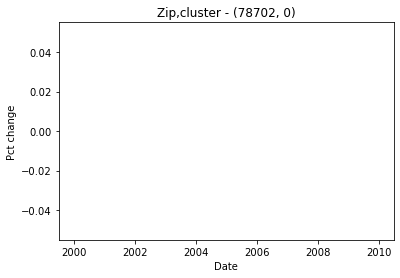

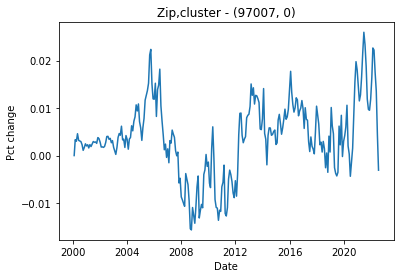

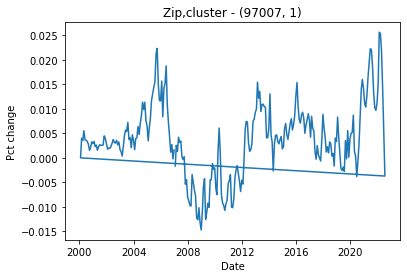

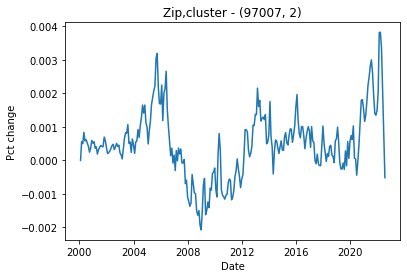

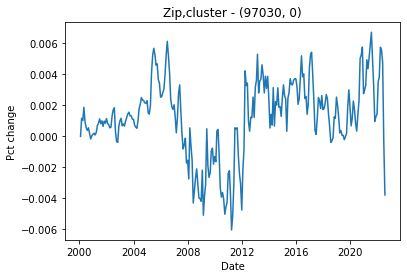

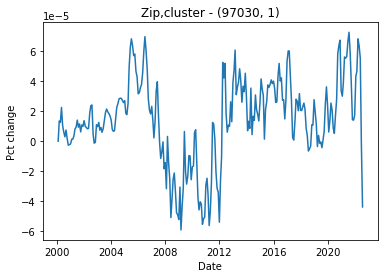

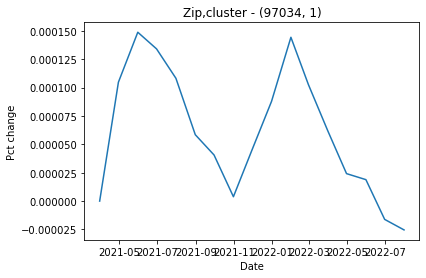

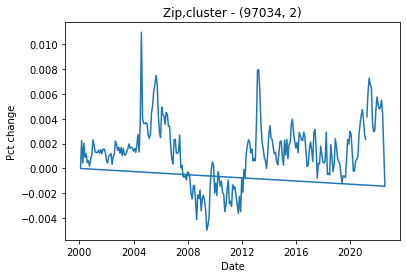

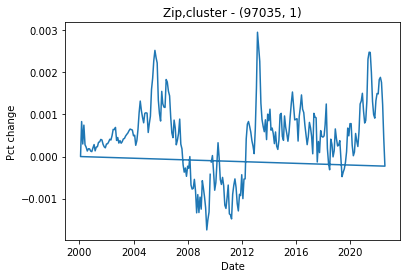

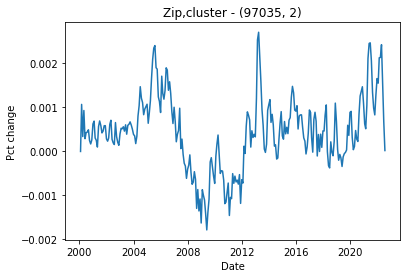

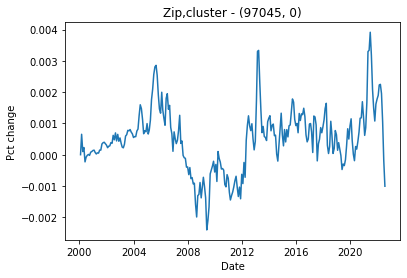

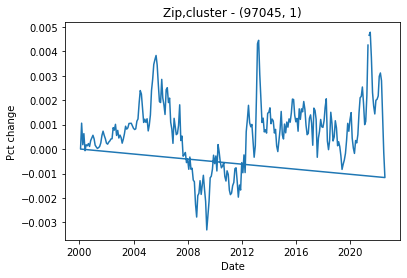

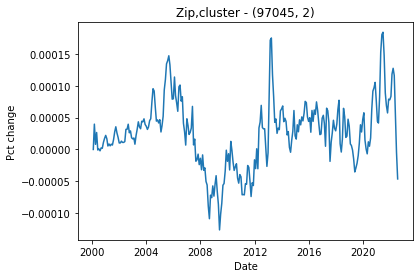

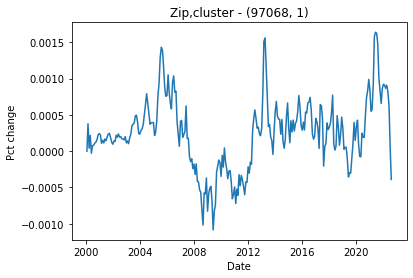

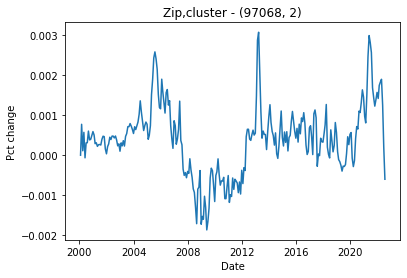

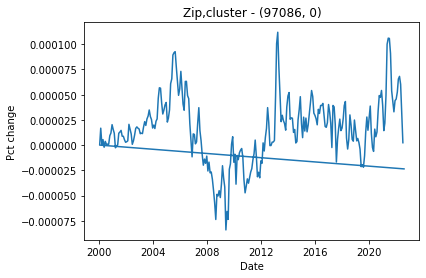

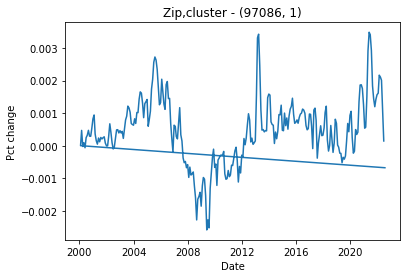

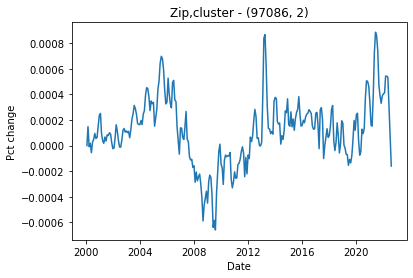

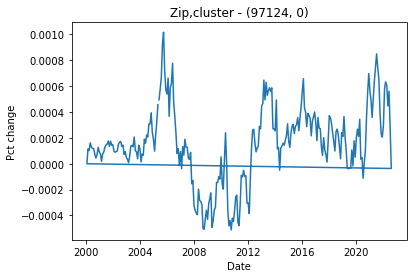

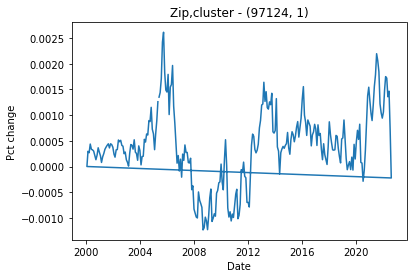

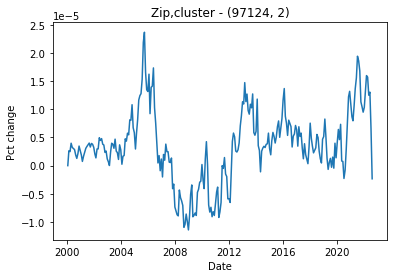

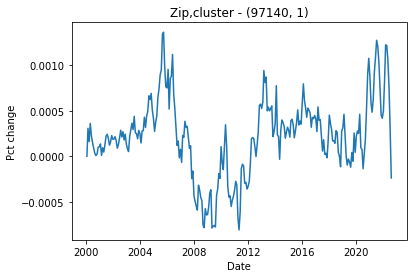

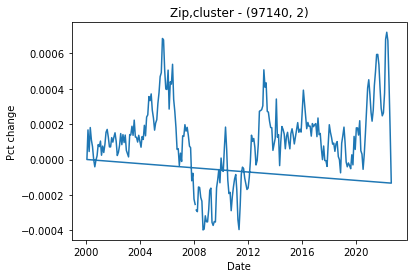

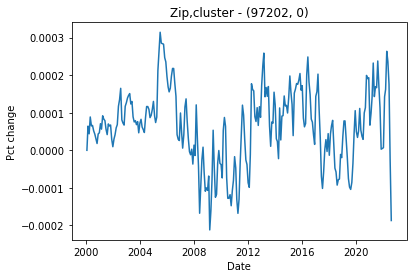

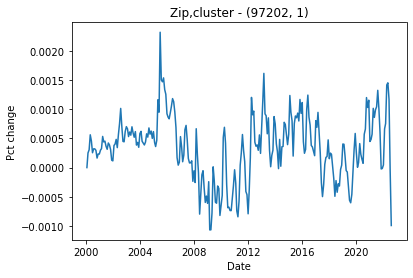

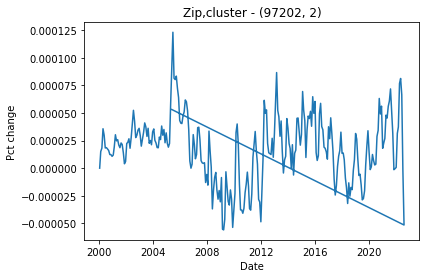

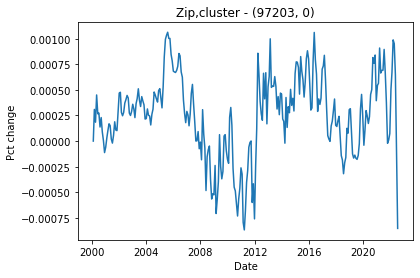

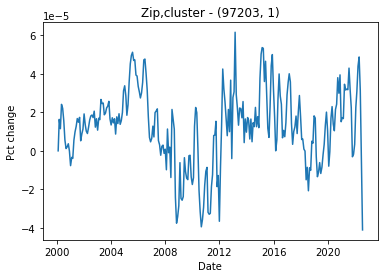

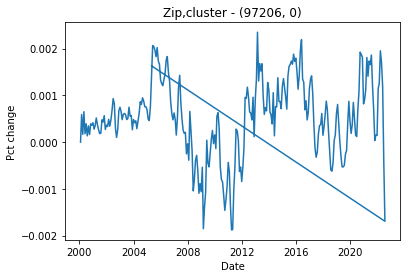

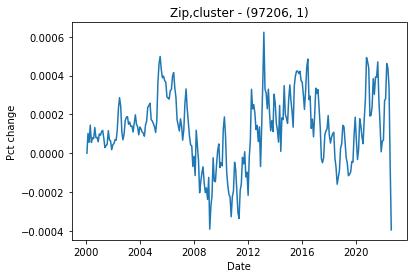

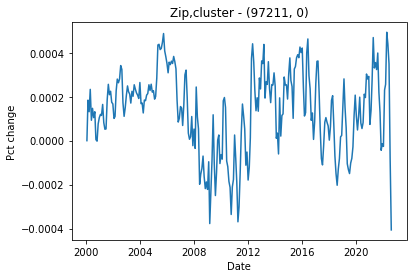

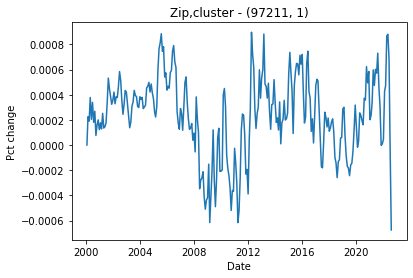

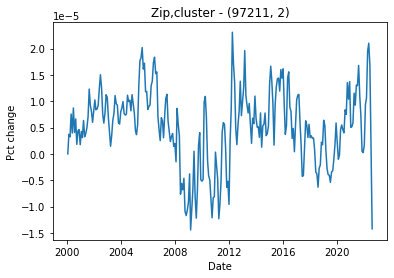

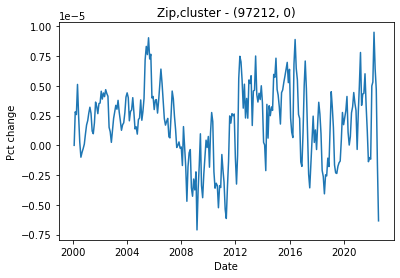

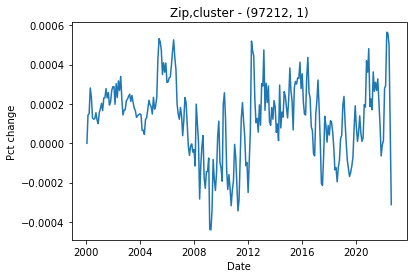

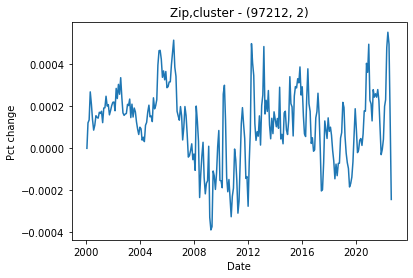

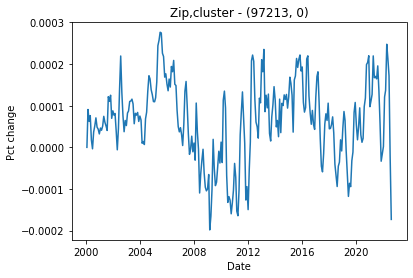

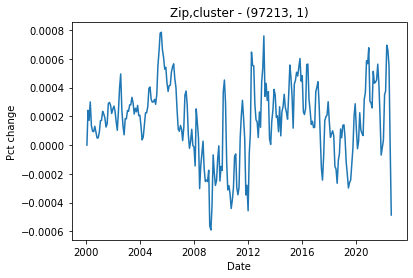

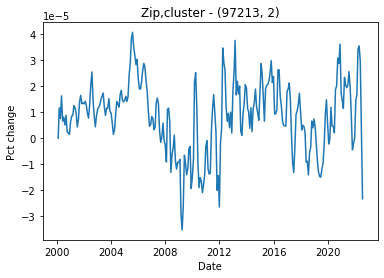

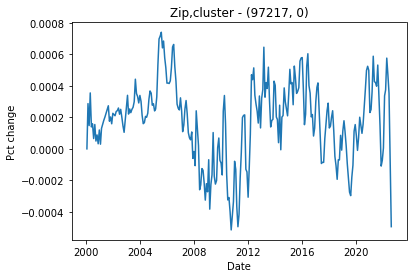

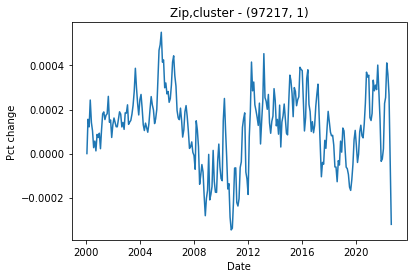

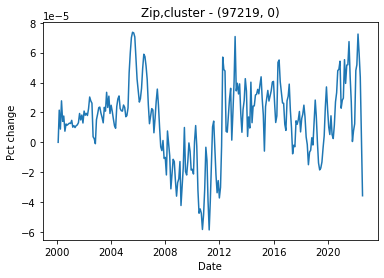

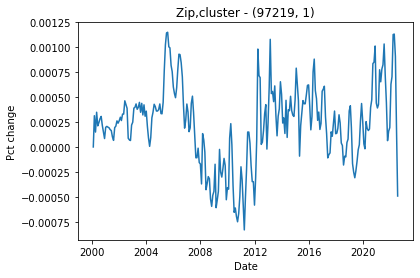

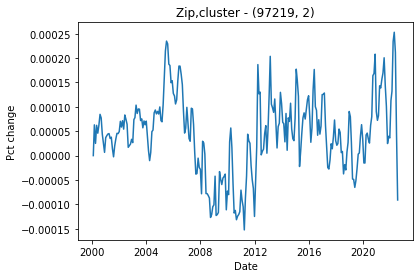

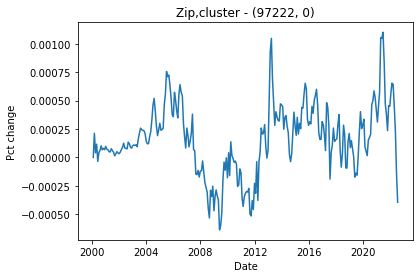

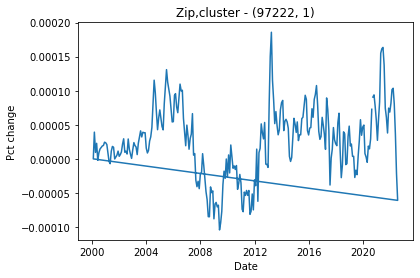

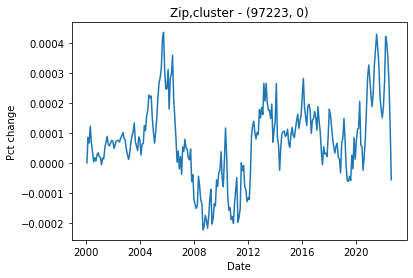

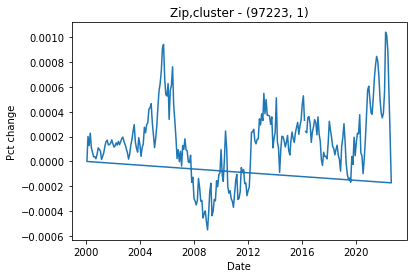

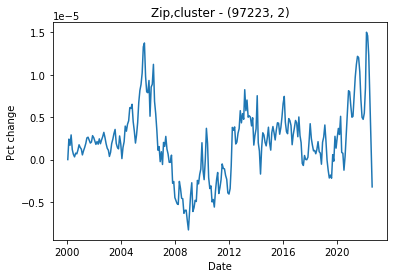

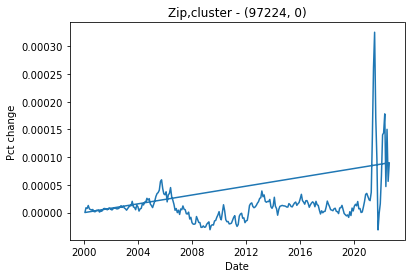

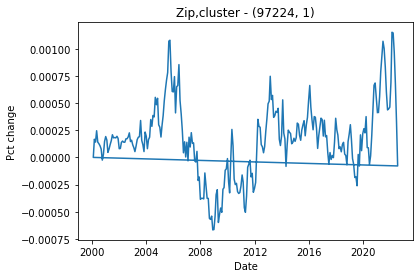

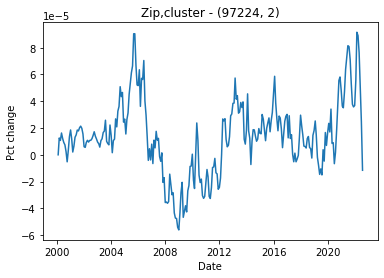

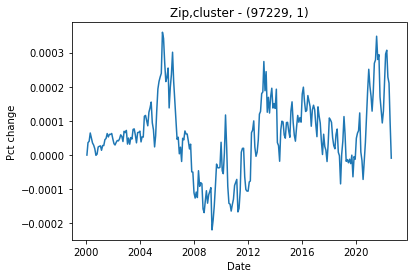

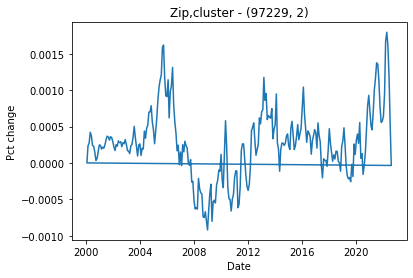

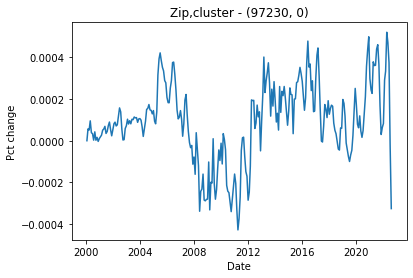

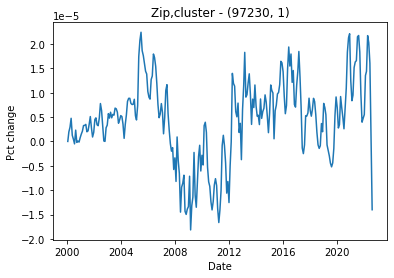

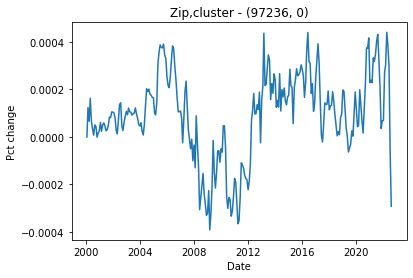

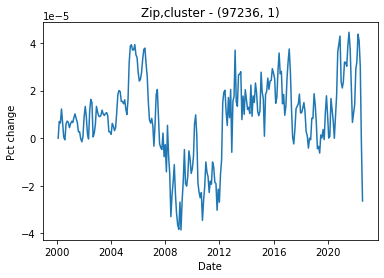

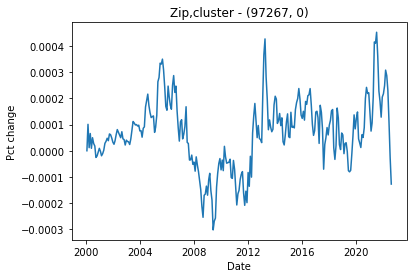

In [92]:
import matplotlib.pyplot as plt
for a in final_holder:
    z=final_holder[a]
    plt.plot(pd.to_datetime(z.index),z[z.columns].sum(axis=1))
    plt.title(f"Zip,cluster - {a}")
    plt.ylabel("Pct change")
    plt.xlabel("Date")
    plt.show()

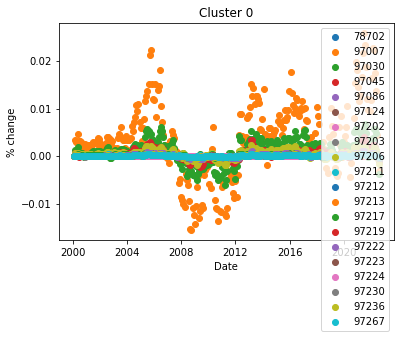

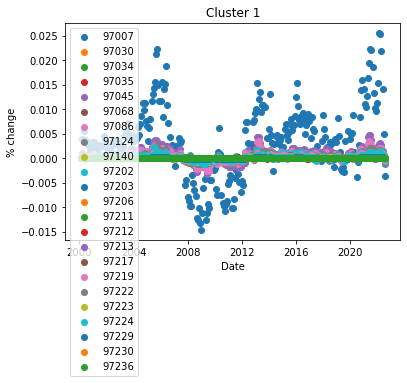

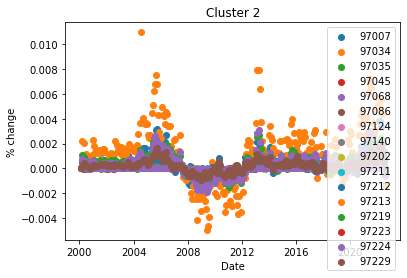

In [94]:
for x in range(3):
    zeros=[final_holder[i] for i in final_holder if i[1] == x]
    zeros_z=[i[0] for i in final_holder if i[1] == x]
    for a,b in zip(zeros,zeros_z):
        plt.scatter(pd.to_datetime(a.index),a[a.columns].sum(axis=1),label=b)
        plt.ylabel("% change")
    plt.title(f"Cluster {x}")
    plt.xlabel("Date")
    plt.legend()
    plt.show()

In [95]:
def weight(x):
    x=x.dropna()
    x=x.sum()/len(x)
    return x


Aggregated portland data

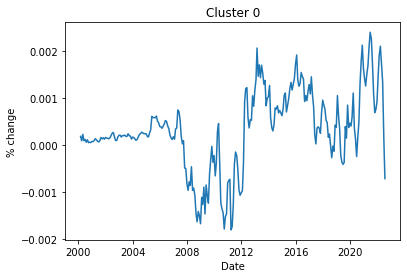

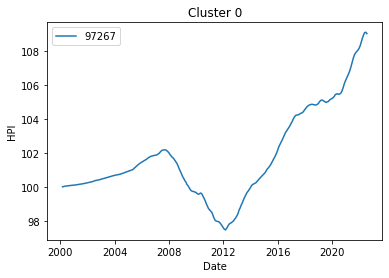

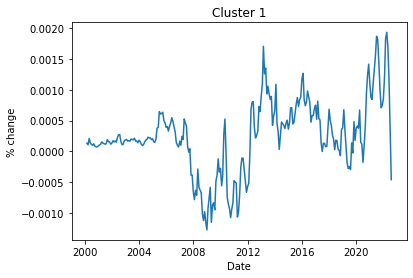

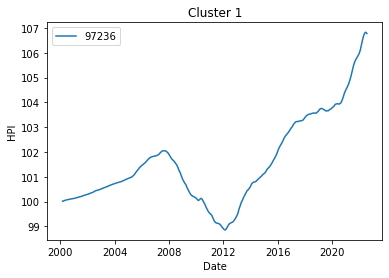

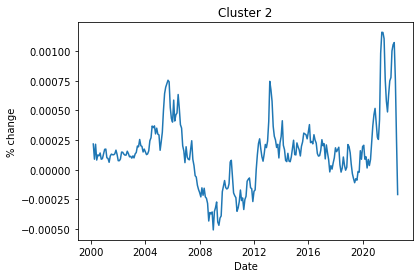

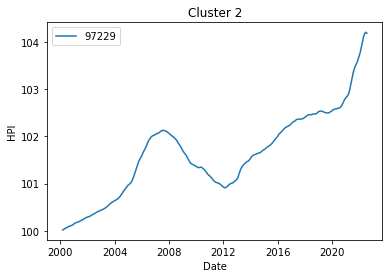

In [97]:
P_output={}
for x in range(3):
    zeros=[final_holder[i] for i in final_holder if i[1] == x]
    zeros_z=[i[0] for i in final_holder if i[1] == x]
    mega=pd.DataFrame()
    for a,b in zip(zeros,zeros_z):
        a=a.dropna(how="any")
        temp=a[a.columns].sum(axis=1)
        mega=pd.concat([mega,temp],axis=1)
    mega.index = pd.to_datetime(mega.index)
    mega=mega.sort_index()
    mega["weighted"]=mega.apply(weight,axis=1)
    base=100
    HPI=[]
    for i in mega["weighted"]:
        HPI.append(base*(1+i))
        base=base*(1+i)
    P_output[x]=[HPI,mega["weighted"]]
    plt.plot(mega.index,mega["weighted"],label=b)
    plt.ylabel("% change")
    plt.title(f"Cluster {x}")
    plt.xlabel("Date")
    plt.show()
    plt.plot(mega.index,HPI,label=b)
    plt.ylabel("HPI")
    plt.title(f"Cluster {x}")
    plt.xlabel("Date")
    plt.legend()
    plt.show()

Note that portland had "one of the worse bubbles" in regards to 2008, which shows here.  Additionally, not steep 0 increase at end is observed

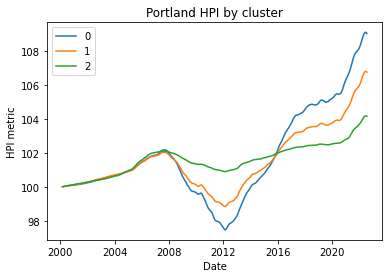

In [103]:
for i in P_output:
    plt.plot(P_output[i][1].index,P_output[i][0],label=i)
plt.title("Portland HPI by cluster")
plt.ylabel("HPI metric")
plt.xlabel("Date")
plt.legend()

### Equal weight the cities together for net effect

This should give a better understanding of the national scale for the metro area (Assume with more data this will convege to HPI for USA (CLT type approach))

In [99]:
net_output={}
for i in output:
    net_output[i]=[]
    if i == 2:
        g=P_output[2][0][1:]
        net_output[i].append([sum(x)/2 for x in zip(output[i][0], g)])
        net_output[i].append((output[i][1] + P_output[i][1])/2)
    else:
        net_output[i].append([sum(x)/2 for x in zip(output[i][0], P_output[i][0])])
        net_output[i].append((output[i][1] + P_output[i][1])/2)

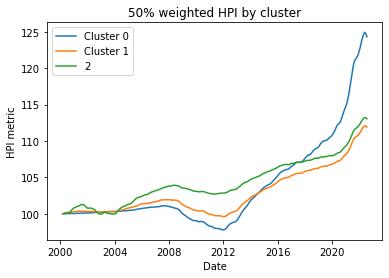

In [102]:
f=net_output[2][1].iloc[1:].index
for i in net_output:
    if i ==2:
        plt.plot(f,net_output[i][0],label=i)
    else:
        plt.plot(net_output[i][1].index,net_output[i][0],label=f"Cluster {i}")
plt.title("50% weighted HPI by cluster")
plt.ylabel("HPI metric")
plt.xlabel("Date")
plt.legend()

### TASK 3, Link cluster to income values

Austin first, Assumes that income is wieghted average of morgage payments by how much of the houses were found in that zip code (note very granualar agi stubs )

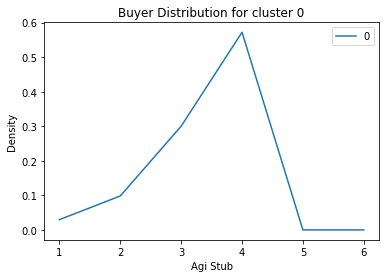

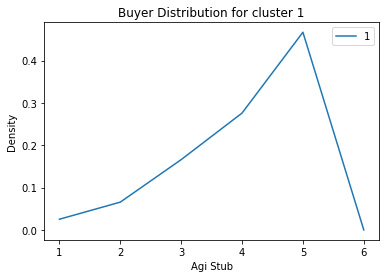

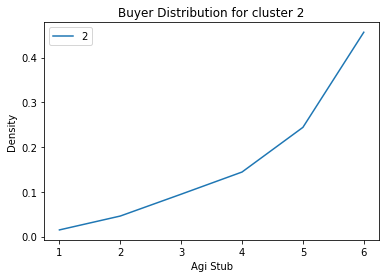

Note that the prices to agi conversion are as follows:
1 : <25k
2 : 25-50k
3 : 50-100k
4 : 100-150
5 : 150-250k
6 : >300k


{0: agi_stub
 1    0.029651
 2    0.098255
 3    0.300123
 4    0.571971
 5    0.000000
 6    0.000000
 dtype: float64,
 1: agi_stub
 1    0.025257
 2    0.065633
 3    0.166053
 4    0.276056
 5    0.467001
 6    0.000000
 dtype: float64,
 2: agi_stub
 1    0.014871
 2    0.045883
 3    0.094673
 4    0.144193
 5    0.243958
 6    0.456422
 dtype: float64}

In [106]:
soi = pd.read_csv("./data/19zpallagi.csv")
austin=pd.read_pickle("Austin_3_cluster.pkl")
soi
austin_zips = austin['zipcode'].unique()
data_city = soi[soi['zipcode'].isin(austin_zips)]
data_city
holder = pd.DataFrame()
holder["med_real_est_tax"]=data_city.groupby(["zipcode", "agi_stub"]).median()["A18500"]/data_city.groupby("agi_stub").median()["N02650"]
holder["mean_real_est_tax"]=data_city.groupby(["zipcode", "agi_stub"]).mean()["A18500"]/data_city.groupby("agi_stub").mean()["N02650"]
holder["med_morgage_payment"]=data_city.groupby(["zipcode", "agi_stub"]).median()["A18300"]/data_city.groupby("agi_stub").median()["N02650"]
holder["mean_morgage_payment"]=data_city.groupby(["zipcode", "agi_stub"]).mean()["A18300"]/data_city.groupby("agi_stub").mean()["N02650"] 
holder # 48 zips 6 agi stubs per
data_city = soi[soi['zipcode'].isin(austin_zips)]
norm_med_tax = {}
norm_mn_tax = {}
norm_med_payment = {}
norm_mn_payment = {}

for zipcode in data_city['zipcode'].unique():
    temp = data_city[data_city['zipcode'] == zipcode]
    
    med_tax = temp.groupby("agi_stub").median()["A18500"]/temp.groupby("agi_stub").median()["N02650"]
    mn_tax = temp.groupby("agi_stub").mean()["A18500"]/temp.groupby("agi_stub").mean()["N02650"]
    norm_med_tax[zipcode] = med_tax
    norm_mn_tax[zipcode] = mn_tax
    
    med_payment = temp.groupby("agi_stub").median()["A18300"]/temp.groupby("agi_stub").median()["N02650"]
    mn_payment = temp.groupby("agi_stub").mean()["A18300"]/temp.groupby("agi_stub").mean()["N02650"]
    norm_med_payment[zipcode] = med_payment
    norm_mn_payment[zipcode] = mn_payment

norm_med_tax
broken=austin.groupby(['zipcode',"cluster"])
easier={}
for t,b in broken:
    easier[t]=len(b)

holder_1 = {}

clusters = np.array([0,0,0])
for a,b in easier:
    temp=norm_mn_payment[a] # can change this to norm_mn_payment, norm_med_tax, norm_mn_tax
    val_t=temp*easier[(a,b)]
    if b not in holder_1.keys():
        holder_1[b] = val_t
    else:
        holder_1[b] += val_t
        
    clusters[b]+=easier[(a,b)]

holder_1
for i in holder_1:
    holder_1[i] = holder_1[i]/clusters[i]
    holder_1[i] /= holder_1[i].sum()
    holder_1[i] = holder_1[i].fillna(0)
    plt.plot(holder_1[i].index, holder_1[i], label=i)
    plt.xlabel("Agi Stub")
    plt.ylabel("Density")
    plt.title(f"Buyer Distribution for cluster {i}")
    plt.legend()
    plt.show()
    
holder_1 # contains proportion of real estate tax paid by each agi stub within each cluster
print("Note that the prices to agi conversion are as follows:")
print("1 : <25k")
print("2 : 25-50k")
print("3 : 50-100k")
print("4 : 100-150")
print("5 : 150-250k")
print("6 : >300k")
# NOTE FOR GREG: use median tax rate for the best effect
austin.groupby('cluster').describe()
holder_1

Portland Below, Note that portland cost of living is higher as is housing by signifcant margin.  The income mismatches on a national scale so the links are noticables skewed (trend is correct supporting somewhat the idea.... This is major assumption")

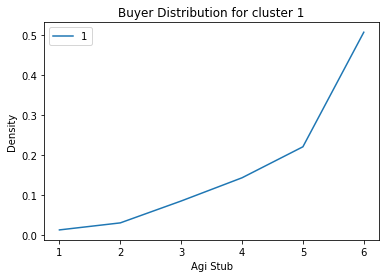

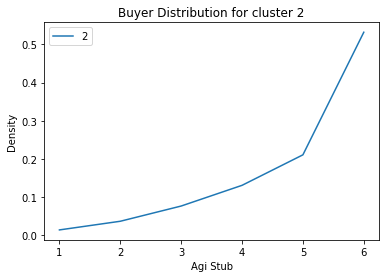

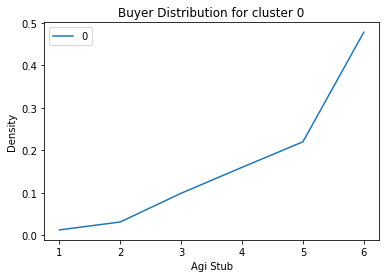

address/zipcode                                                      \
                  count          mean        std      min      25%      50%   
cluster                                                                       
0                6176.0  97161.960816  87.847330  97005.0  97060.0  97211.0   
1                7970.0  97144.987704  83.434829  97004.0  97062.0  97202.0   
2                3449.0  97144.768339  86.396005  97004.0  97045.0  97205.0   

                          bathrooms                                          \
             75%      max     count      mean       std  min  25%  50%  75%   
cluster                                                                       
0        97223.0  97267.0    6176.0  2.009715  0.771708  1.0  1.0  2.0  3.0   
1        97219.0  97267.0    7970.0  2.732246  0.703202  1.0  2.0  3.0  3.0   
2        97229.0  97267.0    3449.0  3.562192  1.011665  1.0  3.0  3.0  4.0   

              bedrooms                                               dateSold  \
          max    count      mean       std  min  25%  50%  75%   max    count   
cluster                                                                         
0         8.0   6176.0  3.009553  0.721945  0.0  3.0  3.0  3.0   8.0   6176.0   
1         9.0   7970.0  3.532246  0.765865  0.0  3.0  3.0  4.0   9.0   7970.0   
2        10.0   3449.0  4.262395  0.854144  2.0  4.0  4.0  5.0  10.0   3449.0   

                                                                               \
                 mean           std           min           25%           50%   
cluster                                                                         
0        1.610519e+12  9.957964e+09  1.591920e+12  1.601420e+12  1.610320e+12   
1        1.610570e+12  1.006915e+10  1.592270e+12  1.601420e+12  1.610410e+12   
2        1.610803e+12  9.981581e+09  1.593990e+12  1.601860e+12  1.610580e+12   

                                    daysOnZillow                               \
                  75%           max        count        mean         std  min   
cluster                                                                         
0        1.619740e+12  1.626390e+12       6175.0  187.840324  112.444516  3.0   
1        1.620170e+12  1.626390e+12       7970.0  188.103011  114.434563  2.0   
2        1.620350e+12  1.626390e+12       3449.0  186.763700  114.056894  2.0   

                                   favoriteCount                            \
          25%    50%    75%    max         count      mean        std  min   
cluster                                                                      
0        83.0  193.0  293.0  364.0        2546.0  1.571877  12.157502  0.0   
1        78.0  193.0  296.0  364.0        2824.0  1.017705   9.162274  0.0   
2        77.0  191.0  292.0  364.0        1654.0  1.122733  10.213572  0.0   

                              lastSoldPrice                               \
         25%  50%  75%    max         count          mean            std   
cluster                                                                    
0        0.0  0.0  0.0  224.0        6176.0  4.453787e+05  110894.797431   
1        0.0  0.0  0.0  273.0        7970.0  5.978570e+05  157230.057560   
2        0.0  0.0  0.0  295.0        3449.0  1.022663e+06  516591.157802   

                                                            latitude  \
              min       25%       50%        75%        max    count   
cluster                                                                
0          8000.0  360000.0  432000.0   520000.0  1300000.0   6176.0   
1         17413.0  500000.0  575000.0   675000.0  1830000.0   7970.0   
2        290000.0  707888.0  870000.0  1195000.0  6300000.0   3449.0   

                                                                          \
              mean       std        min        25%        50%        75%   
cluster                                                                    
0        4

In [107]:
soi = pd.read_csv("./data/19zpallagi.csv")
austin=pd.read_pickle("portland_3_cluster.pkl")
austin["zipcode"]=austin['address/zipcode']
austin_zips = austin['zipcode'].unique()
data_city = soi[soi['zipcode'].isin(austin_zips)]
data_city
holder = pd.DataFrame()
holder["med_real_est_tax"]=data_city.groupby(["zipcode", "agi_stub"]).median()["A18500"]/data_city.groupby("agi_stub").median()["N02650"]
holder["mean_real_est_tax"]=data_city.groupby(["zipcode", "agi_stub"]).mean()["A18500"]/data_city.groupby("agi_stub").mean()["N02650"]
holder["med_morgage_payment"]=data_city.groupby(["zipcode", "agi_stub"]).median()["A18300"]/data_city.groupby("agi_stub").median()["N02650"]
holder["mean_morgage_payment"]=data_city.groupby(["zipcode", "agi_stub"]).mean()["A18300"]/data_city.groupby("agi_stub").mean()["N02650"] 
holder # 48 zips 6 agi stubs per
data_city = soi[soi['zipcode'].isin(austin_zips)]
norm_med_tax = {}
norm_mn_tax = {}
norm_med_payment = {}
norm_mn_payment = {}

for zipcode in data_city['zipcode'].unique():
    temp = data_city[data_city['zipcode'] == zipcode]
    
    med_tax = temp.groupby("agi_stub").median()["A18500"]/temp.groupby("agi_stub").median()["N02650"]
    mn_tax = temp.groupby("agi_stub").mean()["A18500"]/temp.groupby("agi_stub").mean()["N02650"]
    norm_med_tax[zipcode] = med_tax
    norm_mn_tax[zipcode] = mn_tax
    
    med_payment = temp.groupby("agi_stub").median()["A18300"]/temp.groupby("agi_stub").median()["N02650"]
    mn_payment = temp.groupby("agi_stub").mean()["A18300"]/temp.groupby("agi_stub").mean()["N02650"]
    norm_med_payment[zipcode] = med_payment
    norm_mn_payment[zipcode] = mn_payment

norm_med_tax
broken=austin.groupby(['zipcode',"cluster"])
easier={}
for t,b in broken:
    easier[t]=len(b)

holder = {}

clusters = np.array([0,0,0])
for a,b in easier:
    temp=norm_mn_tax[a] # can change this to norm_mn_payment, norm_med_tax, norm_mn_tax
    val_t=temp*easier[(a,b)]
    if b not in holder.keys():
        holder[b] = val_t
    else:
        holder[b] += val_t
        
    clusters[b]+=easier[(a,b)]

holder
for i in holder:
    holder[i] = holder[i]/clusters[i]
    holder[i] /= holder[i].sum()
    holder[i] = holder[i].fillna(0)
    plt.plot(holder[i].index, holder[i], label=i)
    plt.xlabel("Agi Stub")
    plt.ylabel("Density")
    plt.title(f"Buyer Distribution for cluster {i}")
    plt.legend()
    plt.show()
    
holder # contains proportion of real estate tax paid by each agi stub within each cluster

# NOTE FOR GREG: use median tax rate for the best effect
austin.groupby('cluster').describe()

### Combine the citities equally
We hope that adding more cities will smooth the distribution nationally

1


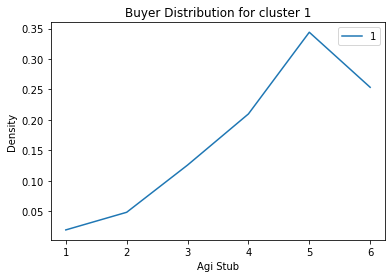

2


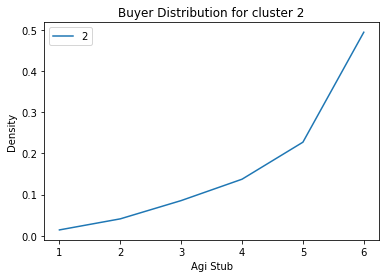

0


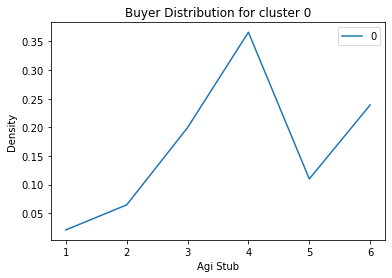

In [108]:
for i in holder:
    print(i)
    temp=holder_1[i]+holder[i]
    temp=temp/2
    plt.plot(temp.index, temp, label=i)
    plt.legend()
    plt.xlabel("Agi Stub")
    plt.ylabel("Density")
    plt.title(f"Buyer Distribution for cluster {i}")
    plt.show()

This data is prepared for presentation.  The takeaways and complete story is told there, but to summarize:
- We hypothesize that there are different housing segments in the market
- We found the natural segmentation of the housing markets
- We proved the model works by looking at the location map
- Linked the segmentation to who is buying the homes
- Used the segmentation to generate HPI by city
- Proved by the fact there is different HPI by city
- Saw the housing problem is localized to low income individuals
- This creates enough data to regress on HPI and see
    - What houses are being bought by segment
    - How do those sub segments change
    - What is important for each market 
    - Who are we directly effecting